<h1> Get Outside: </h1>
<hr>
<h2>Predicting Annual Visits to the Nation's 5 most-visited national Parks<h2/>
<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

In [1]:
# import image module
from IPython.display import Image

# get the image
Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Logo_of_the_United_States_National_Park_Service.svg/1920px-Logo_of_the_United_States_National_Park_Service.svg.png", width=300, height=300)


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

## Executive Summary:

### 1. This project analyzed data from NPS records going back to 1979 at the nation's top 5 most visited national parks to predict visitors for the final 6 years on record, 2016-2021.

### 2. The best predictive model is a seasonal analysis mdoel, using trend data and historical patterns to predict future park visits. The error rate (RMSE) produced in the final forecast is 1.8 mn visits, or roughly 25% of total estimated visits. The period for estimated visits notably included an anomaly event, the 2020 pandemic, that may have afffected the final error rate



<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

## Project Outline:

### 1. Acquire/Prepare: Source the data from NPS.GOV and produced a composite dataframe for 5 parks and a total visits column for Exploration and Modeling.

### 2. Data Exploration: explored the distribution and seasonality of visits to determine peak periodds of visitation, as well as individual park trends if they exist. Also use seasonal decompostion to identify underlying trends.

### 3. Modeling: Create models that will forecast visitorship, using Time Series methods including last observed value, simple moving average, rolling average, Holts-Winter linear method, and Seasonal Trend.

### 4. Conclusion and Next Steps: measure the results of the best predictive model and suggest next steps.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

In [2]:
import wrangle

## 1. Acquire/Prepare:

- I acquired the CSVs from the NPS website for the following parks:

    - zion_url = 'https://irma.nps.gov/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)?Park=ZION'

    - grand_canyon_url = 'https://irma.nps.gov/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)?Park=GRCA'

    - great_smokey_mtns_url = 'https://irma.nps.gov/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)?Park=GRSM'

    - yellowstone_url = 'https://irma.nps.gov/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)?Park=YELL'

    - rocky_mtn_url = 'https://irma.nps.gov/STATS/SSRSReports/Park%20Specific%20Reports/Recreation%20Visitors%20By%20Month%20(1979%20-%20Last%20Calendar%20Year)?Park=ROMO'

- the CSVs yielded monthly records of park vistiorship from 1979-2022 (current month), with no null data. This was simple from the Data Cleaning angle.

- I built import functions to read the CSVs, and merge into a combined Data Frame for exploration and modeling.

- the functions are avaialble in the scratch notebook, as well as the wrange.py file in the Repo.

- this yielded a final dataframe with 521 rows, and 5 original park columns, as well as a composite total visitors column.


In [3]:
df = wrangle.cleaned_and_prepped_NPS_visitors()
df.head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns
date                                                                      
1979-01-01        23605         37002      53585    8994            130261
1979-02-01        31992         46043      85931   12106            160764
1979-03-01        17813         91927      75070   23079            309163
1979-04-01        34095        123643      66873   63306            650485
1979-05-01       108952        205048      79577  122964            666017

In [116]:
df.shape[0]

521

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

## 2. Explore:

- I explored the visitor distributions overall, and then conducted a seasonal decompostiion to examine the underlying trends of the data for later use in the modeling phase.


In [4]:
import acquire
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [7]:
print("Date Range is: ", df.index.min(), 'to', df.index.max())
print('Shape', df.shape[0])

Date Range is:  1979-01-01 00:00:00 to 2022-05-01 00:00:00
Shape 521


In [8]:
df['total_visits'] = df.yellowstone + df.grand_canyon + df.great_smoky_mtns + df.zion + df.rocky_mtn

In [9]:
df.head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns  \
date                                                                         
1979-01-01        23605         37002      53585    8994            130261   
1979-02-01        31992         46043      85931   12106            160764   
1979-03-01        17813         91927      75070   23079            309163   
1979-04-01        34095        123643      66873   63306            650485   
1979-05-01       108952        205048      79577  122964            666017   

            total_visits  
date                      
1979-01-01        253447  
1979-02-01        336836  
1979-03-01        517052  
1979-04-01        938402  
1979-05-01       1182558

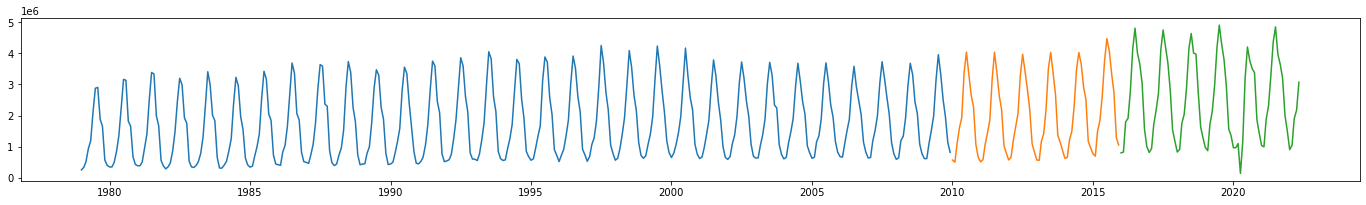

In [10]:
#manual split (roughly 70% of data)

# train is the data up to 2010-01-01
train = df[:'2009']
# validate is the data up to 2016-01-01
validate = df['2010':'2015']
# test is the data after 2016-01-01
test = df['2016':]

plt.rc('figure', figsize=(24, 3))
plt.plot(train.index, train.total_visits)
plt.plot(validate.index, validate.total_visits)
plt.plot(test.index, test.total_visits)


In [11]:
print("Train Date Range is: ", train.index.min(), 'to', train.index.max())
print('Train Shape', train.shape[0])

Train Date Range is:  1979-01-01 00:00:00 to 2009-12-01 00:00:00
Train Shape 372


In [12]:
print("Validate Date Range is: ", validate.index.min(), 'to', validate.index.max())
print('Validate Shape', validate.shape[0])

Validate Date Range is:  2010-01-01 00:00:00 to 2015-12-01 00:00:00
Validate Shape 72


In [13]:
print("Test Date Range is: ", test.index.min(), 'to', test.index.max())
print('Test Shape', test.shape[0])

Test Date Range is:  2016-01-01 00:00:00 to 2022-05-01 00:00:00
Test Shape 77


In [14]:
train.columns

Index(['yellowstone', 'grand_canyon', 'rocky_mtn', 'zion', 'great_smoky_mtns',
       'total_visits'],
      dtype='object')

In [15]:
y1 = train.total_visits
y2 = train.yellowstone
y3 = train.grand_canyon
y4 = train.rocky_mtn
y5 = train.zion
y6 = train.great_smoky_mtns

In [16]:
y1.index = pd.to_datetime(y1.index)
y2.index = pd.to_datetime(y2.index)
y3.index = pd.to_datetime(y3.index)
y4.index = pd.to_datetime(y4.index)
y5.index = pd.to_datetime(y5.index)
y6.index = pd.to_datetime(y6.index)

## First, let's take a look at the overall distribution of annual visitors, independent of time

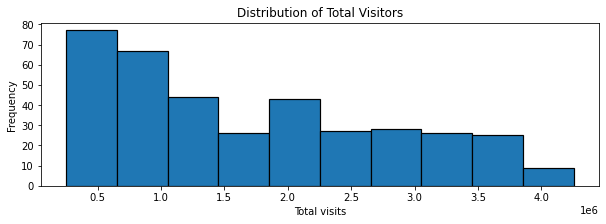

In [17]:
# Histogram
plt.rc('figure', figsize=(10, 3))
plt.title('Distribution of Total Visitors')
plt.xlabel('Total visits')
y1.plot.hist(linewidth=1.2, edgecolor='black')
plt.rc('font', size=5)

### Takeaways:
- for aggregate visits to the 5 parks ('total visitors'):
    - there's a fairly normal right skewed distribution peaking at 75 months with ~500,000 visitors, with an unexpected mini-peak at 2mn visitors.
    - this makes sense: most months tend to be 'off' months, with usage peaking in most parks 3-4 months/year, or 25% percent of the time
    - let's take a look at individual park distributions

<AxesSubplot:title={'center':'Distribution of Yellowstone Visitors'}, xlabel='Yelloswtone visits', ylabel='Frequency'>

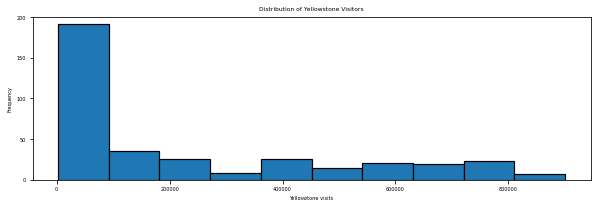

In [18]:
# Histogram
plt.rc('figure', figsize=(10, 3))
plt.title('Distribution of Yellowstone Visitors')
plt.xlabel('Yelloswtone visits')
plt.rc('font', size=15)
y2.plot.hist(linewidth=1.2, edgecolor='black')

<AxesSubplot:title={'center':'Distribution of Grand Canyon Visitors'}, xlabel='Grand Canyon Visitors', ylabel='Frequency'>

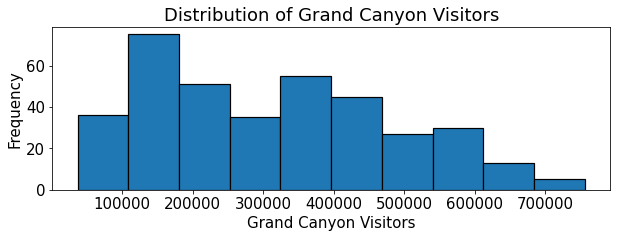

In [19]:
# Histogram
plt.rc('figure', figsize=(10, 3))
plt.title('Distribution of Grand Canyon Visitors')
plt.xlabel('Grand Canyon Visitors')
y3.plot.hist(linewidth=1.2, edgecolor='black')

<AxesSubplot:title={'center':'Distribution of Rocky MTN Visitors'}, xlabel='Rocky MTN Visitors', ylabel='Frequency'>

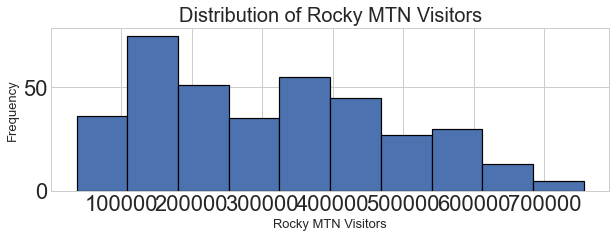

In [117]:
# Histogram

plt.rc('font', size=4) 
plt.rc('figure', figsize=(10, 3))
plt.title('Distribution of Rocky MTN Visitors')
plt.xlabel('Rocky MTN Visitors')
y4.plot.hist(linewidth=1.2, edgecolor='black')

<AxesSubplot:title={'center':'Distribution of Zion Visitors'}, xlabel='Zion Visitors', ylabel='Frequency'>

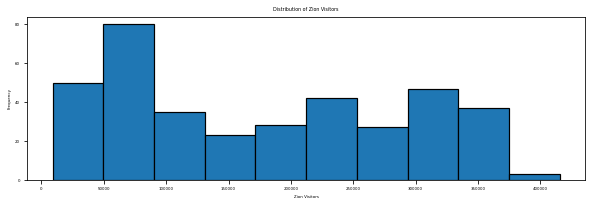

In [21]:
# Histogram
plt.title('Distribution of Zion Visitors')
plt.xlabel('Zion Visitors')
plt.rc('font', size=15)
y5.plot.hist(linewidth=1.2, edgecolor='black')

<AxesSubplot:title={'center':'Distribution of Great Smoky Mountain Visitors'}, xlabel='Great Smoky Mountain Visitors', ylabel='Frequency'>

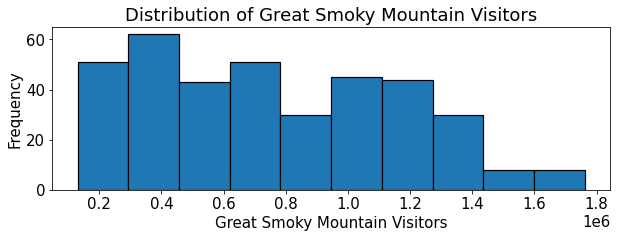

In [22]:
# Histogram
plt.title('Distribution of Great Smoky Mountain Visitors')
plt.xlabel('Great Smoky Mountain Visitors')
plt.rc('font', size=15)
y6.plot.hist(linewidth=1.2, edgecolor='black')

## Now let's look at monthly trends within the years
    - create a month column with number and month name
    - look at monthly visitors overall and by park

In [23]:
train['month'] = train.index.strftime('%m-%b')
train['year'] = train.index.strftime('%Y')
train.head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns  \
date                                                                         
1979-01-01        23605         37002      53585    8994            130261   
1979-02-01        31992         46043      85931   12106            160764   
1979-03-01        17813         91927      75070   23079            309163   
1979-04-01        34095        123643      66873   63306            650485   
1979-05-01       108952        205048      79577  122964            666017   

            total_visits   month  year  
date                                    
1979-01-01        253447  01-Jan  1979  
1979-02-01        336836  02-Feb  1979  
1979-03-01        517052  03-Mar  1979  
1979-04-01        938402  04-Apr  1979  
1979-05-01       1182558  05-May  1979

<AxesSubplot:xlabel='month'>

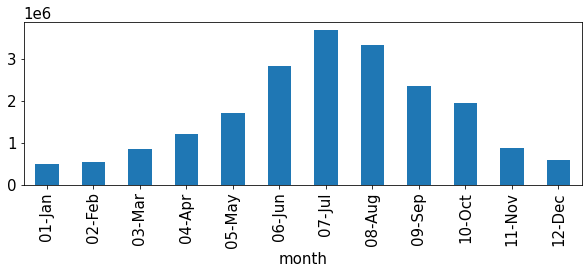

In [24]:
train.groupby(train.month).total_visits.mean().plot.bar()

In [25]:
train.groupby('month').total_visits.describe().round(2).T

month     01-Jan     02-Feb      03-Mar      04-Apr      05-May      06-Jun  \
count      31.00      31.00       31.00       31.00       31.00       31.00   
mean   503596.81  552228.35   853788.74  1205323.06  1716584.32  2830541.45   
std    124131.30  132272.89   228824.90   227879.89   240521.19   277166.38   
min    253447.00  336836.00   474452.00   786346.00  1182558.00  2130857.00   
25%    404015.50  426585.00   704361.00   994849.00  1557150.50  2740621.50   
50%    539665.00  577440.00   912430.00  1260712.00  1766793.00  2935147.00   
75%    610398.00  657583.50  1064008.00  1386512.50  1904744.50  3036243.50   
max    678438.00  798103.00  1189708.00  1522916.00  1987834.00  3165033.00   

month      07-Jul      08-Aug      09-Sep      10-Oct      11-Nov     12-Dec  
count       31.00       31.00       31.00       31.00       31.00      31.00  
mean   3690258.23  3331835.00  2359950.65  1960878.23   894881.29  608898.81  
std     319675.01   253786.54   269898.32   198721.00   200158.48  169627.45  
min    2879067.00  2906446.00  1822682.00  1554141.00   533096.00  310960.00  
25%    3516181.00  3151436.00  2160644.00  1838345.50   749046.00  435321.50  
50%    3712546.00  3316879.00  2436548.00  1985339.00   868762.00  655317.00  
75%    3872658.00  3566136.50  2577238.00  2118105.50  1076300.00  762643.50  
max    4254803.00  3824733.00  2794044.00  2300928.00  1182092.00  824865.00

<AxesSubplot:xlabel='year'>

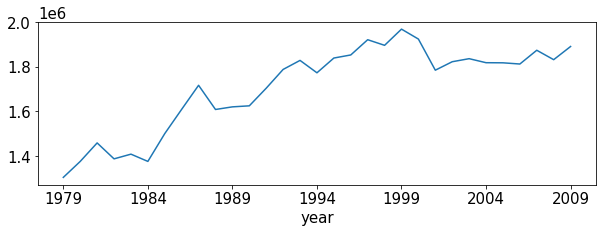

In [27]:
train.groupby('year').total_visits.mean().plot()

### The summer months (JUN-AUG) are the most popular segment. 
- is this trend the across parks?

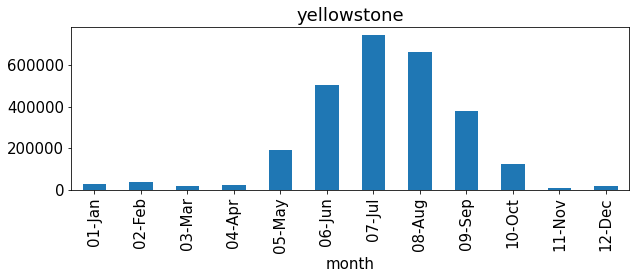

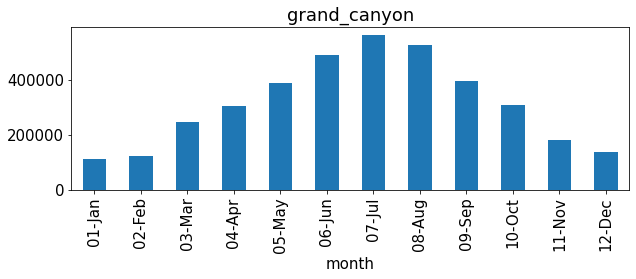

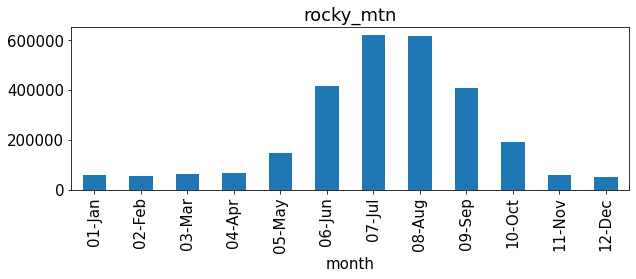

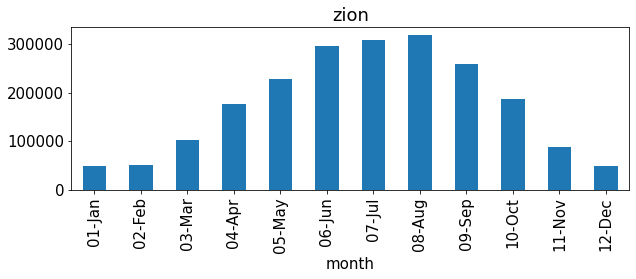

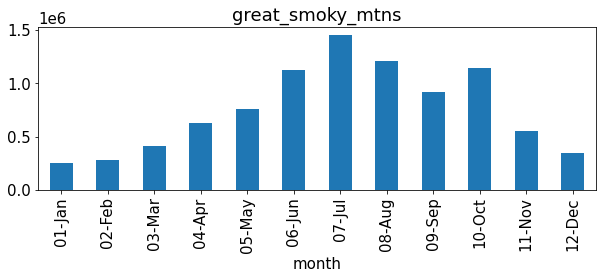

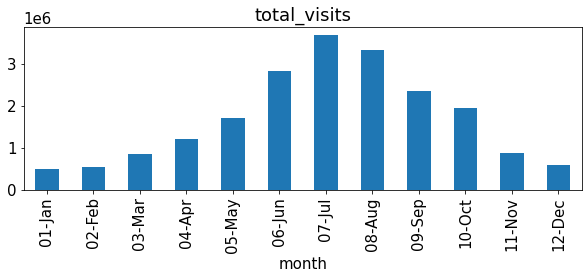

In [29]:
# def park_popularity_by_month(df):
columns = ['yellowstone', 'grand_canyon', 'rocky_mtn', 'zion', 'great_smoky_mtns', 'total_visits']
for col in columns:
    train.groupby(train.month)[col].mean().plot.bar(title=col)
    plt.rc('font', size=15)
    plt.show()

## Takeaway: Great Smoky Mountains is the only NP with a non-Summer month in the top-3 most visited months (OCT is the third most popular month)

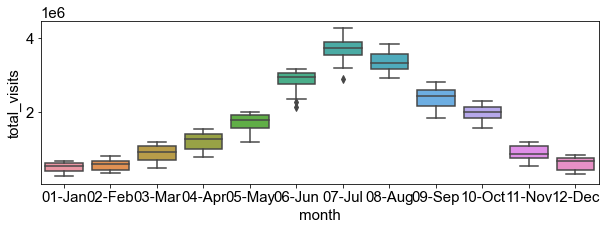

In [30]:
sns.boxplot(data = train, x = train.month, y = train.total_visits)
sns.set(font_scale=2)

## Does this trend hold true across decades?

In [31]:
print("Date Range is: ", train.index.min(), 'to', train.index.max())
print('Shape', train.shape[0])

Date Range is:  1979-01-01 00:00:00 to 2009-12-01 00:00:00
Shape 372


In [33]:
the_1970s_yellowstone = pd.DataFrame(train.yellowstone[(train.index >= '1970-01-01') & (train.index < '1980-01-01')])
the_1970s_grand_canyon = pd.DataFrame(train.grand_canyon[(train.index >= '1970-01-01') & (train.index < '1980-01-01')])
the_1970s_great_smoky_mtns = pd.DataFrame(train.great_smoky_mtns[(train.index >= '1970-01-01') & (train.index < '1980-01-01')])
the_1970s_zion = pd.DataFrame(train.zion[(train.index >= '1970-01-01') & (train.index < '1980-01-01')])
the_1970s_rocky_mtn = pd.DataFrame(train.rocky_mtn[(train.index >= '1970-01-01') & (train.index < '1980-01-01')])
the_1970s_total_visits = pd.DataFrame(train.total_visits[(train.index >= '1970-01-01') & (train.index < '1980-01-01')])

the_1980s_yellowstone = pd.DataFrame(train.yellowstone[(train.index >= '1980-01-01') & (train.index < '1990-01-01')])
the_1980s_grand_canyon = pd.DataFrame(train.grand_canyon[(train.index >= '1980-01-01') & (train.index < '1990-01-01')])
the_1980s_great_smoky_mtns = pd.DataFrame(train.great_smoky_mtns[(train.index >= '1980-01-01') & (train.index < '1990-01-01')])
the_1980s_zion = pd.DataFrame(train.zion[(train.index >= '1980-01-01') & (train.index < '1990-01-01')])
the_1980s_rocky_mtn = pd.DataFrame(train.rocky_mtn[(train.index >= '1980-01-01') & (train.index < '1990-01-01')])
the_1980s_total_visits = pd.DataFrame(train.total_visits[(train.index >= '1980-01-01') & (train.index < '1990-01-01')])

the_1990s_yellowstone = pd.DataFrame(train.yellowstone[(train.index >= '1990-01-01') & (train.index < '2000-01-01')])
the_1990s_grand_canyon = pd.DataFrame(train.grand_canyon[(train.index >= '1990-01-01') & (train.index < '2000-01-01')])
the_1990s_great_smoky_mtns = pd.DataFrame(train.great_smoky_mtns[(train.index >= '1990-01-01') & (train.index < '2000-01-01')])
the_1990s_zion = pd.DataFrame(train.zion[(train.index >= '1990-01-01') & (train.index < '2000-01-01')])
the_1990s_rocky_mtn = pd.DataFrame(train.rocky_mtn[(train.index >= '1990-01-01') & (train.index < '2000-01-01')])
the_1990s_total_visits = pd.DataFrame(train.total_visits[(train.index >= '1990-01-01') & (train.index < '2000-01-01')])

the_2000s_yellowstone = pd.DataFrame(train.yellowstone[(train.index >= '2000-01-01') & (train.index < '2010-01-01')])
the_2000s_grand_canyon = pd.DataFrame(train.grand_canyon[(train.index >= '2000-01-01') & (train.index < '2010-01-01')])
the_2000s_great_smoky_mtns = pd.DataFrame(train.great_smoky_mtns[(train.index >= '2000-01-01') & (train.index < '2010-01-01')])
the_2000s_zion = pd.DataFrame(train.zion[(train.index >= '2000-01-01') & (train.index < '2010-01-01')])
the_2000s_rocky_mtn = pd.DataFrame(train.rocky_mtn[(train.index >= '2000-01-01') & (train.index < '2010-01-01')])
the_2000s_total_visits = pd.DataFrame(train.total_visits[(train.index >= '2000-01-01') & (train.index < '2010-01-01')])



## General Takeaway: The seasonal trends are consistent across parks, and across decades. Let's compare visitorship across parks visually through the decades, then proceed to a seasonal decomposition for trend analysis

No handles with labels found to put in legend.


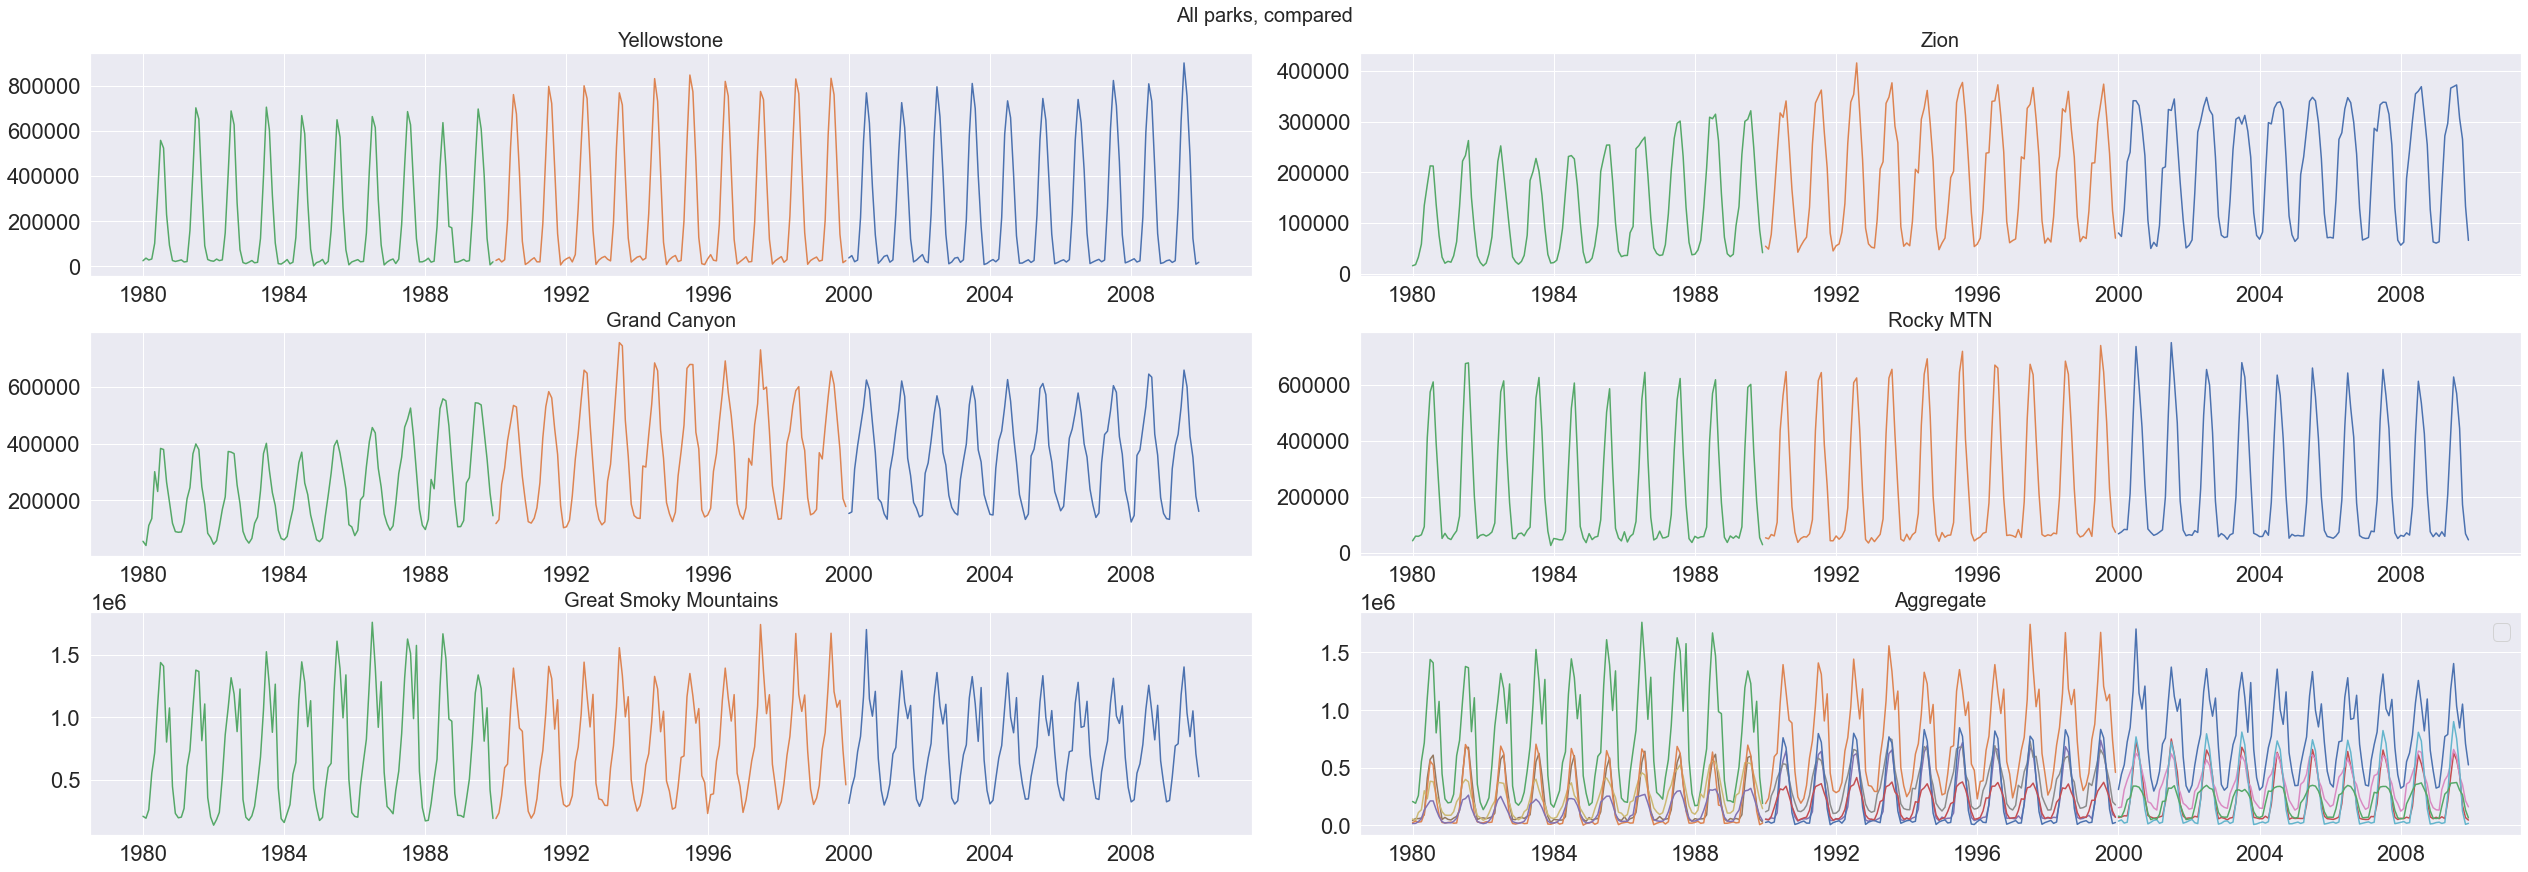

In [40]:
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 20

rows = 3
cols = 2

plt.figure(figsize=(35, 12), constrained_layout=True)

# the fourth subplot
plt.subplot(rows, cols, 1)
plt.plot(the_2000s_yellowstone)
plt.plot(the_1990s_yellowstone)
plt.plot(the_1980s_yellowstone)
plt.title('Yellowstone')

# plot the first subplot
# the fourth subplot
plt.subplot(rows, cols, 2)
plt.plot(the_2000s_zion)
plt.plot(the_1990s_zion)
plt.plot(the_1980s_zion)
plt.title('Zion')

# the second subplot
plt.subplot(rows, cols, 3)
plt.plot(the_2000s_grand_canyon)
plt.plot(the_1990s_grand_canyon)
plt.plot(the_1980s_grand_canyon)
plt.title('Grand Canyon')

# the third subplot
plt.subplot(rows, cols, 4)
plt.plot(the_2000s_rocky_mtn)
plt.plot(the_1990s_rocky_mtn)
plt.plot(the_1980s_rocky_mtn)
plt.title('Rocky MTN')

# the fourth subplot
plt.subplot(rows, cols, 5)
plt.plot(the_2000s_great_smoky_mtns)
plt.plot(the_1990s_great_smoky_mtns)
plt.plot(the_1980s_great_smoky_mtns)
plt.title('Great Smoky Mountains')

plt.subplot(rows, cols, 6)
#plot all the charts against one another
#GSM
plt.plot(the_2000s_great_smoky_mtns)
plt.plot(the_1990s_great_smoky_mtns)
plt.plot(the_1980s_great_smoky_mtns)
#ROCKY
plt.plot(the_2000s_rocky_mtn)
plt.plot(the_1990s_rocky_mtn)
plt.plot(the_1980s_rocky_mtn)
#GC
plt.plot(the_2000s_grand_canyon)
plt.plot(the_1990s_grand_canyon)
plt.plot(the_1980s_grand_canyon)
#Yellowstone
plt.plot(the_2000s_yellowstone)
plt.plot(the_1990s_yellowstone)
plt.plot(the_1980s_yellowstone)
#Zion
plt.plot(the_2000s_zion)
plt.plot(the_1990s_zion)
plt.plot(the_1980s_zion)
plt.title('Aggregate')


plt.suptitle('All parks, compared', fontsize=20)
plt.legend()
plt.show()

No handles with labels found to put in legend.


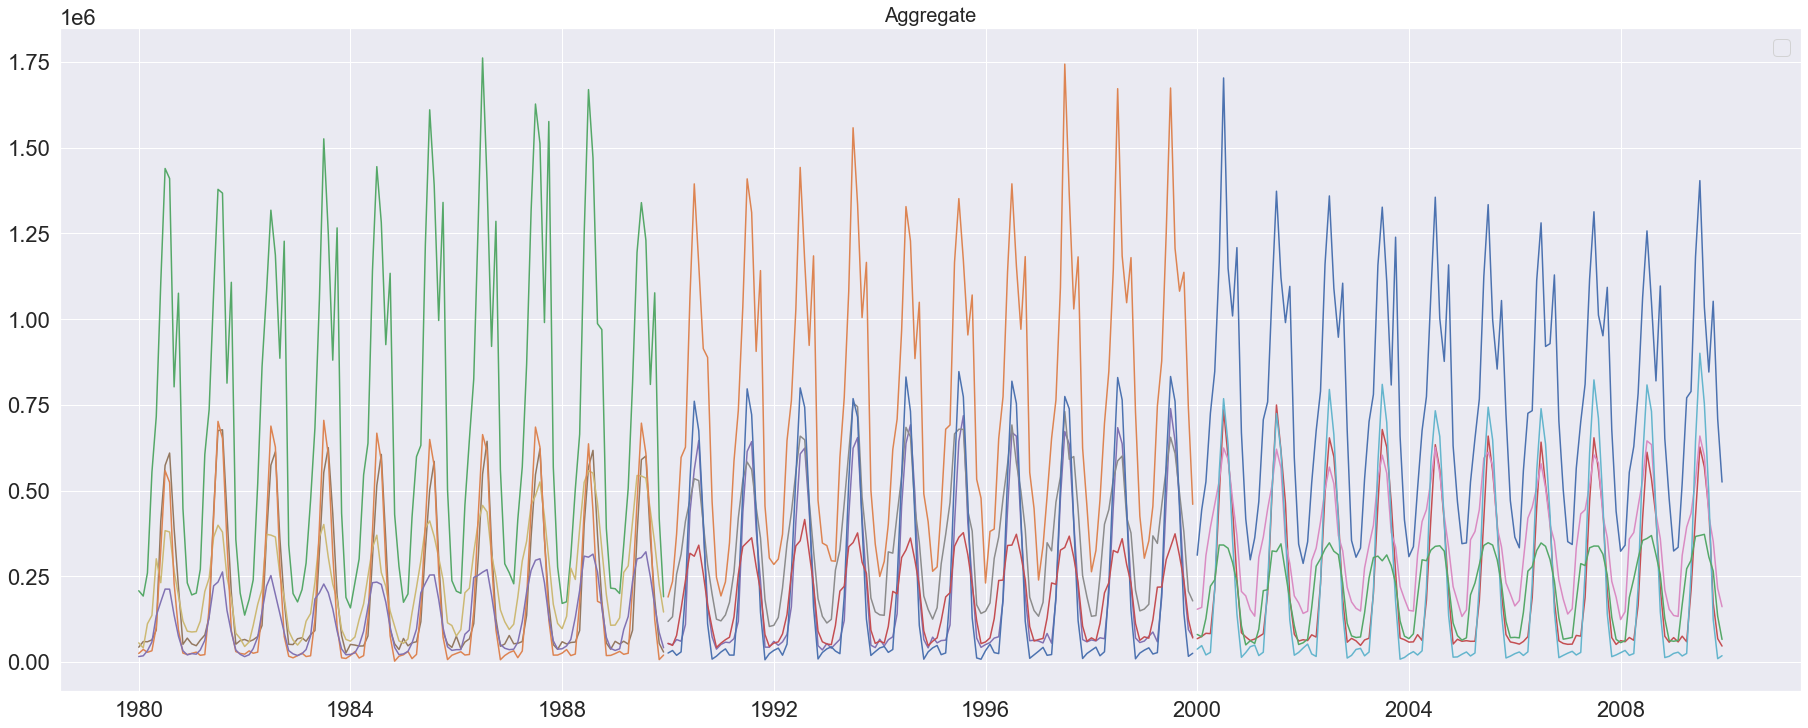

In [41]:
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 20

plt.figure(figsize=(25, 10), constrained_layout=True)
#plot all the charts against one another
#GSM
plt.plot(the_2000s_great_smoky_mtns)
plt.plot(the_1990s_great_smoky_mtns)
plt.plot(the_1980s_great_smoky_mtns)
#ROCKY
plt.plot(the_2000s_rocky_mtn)
plt.plot(the_1990s_rocky_mtn)
plt.plot(the_1980s_rocky_mtn)
#GC
plt.plot(the_2000s_grand_canyon)
plt.plot(the_1990s_grand_canyon)
plt.plot(the_1980s_grand_canyon)
#Yellowstone
plt.plot(the_2000s_yellowstone)
plt.plot(the_1990s_yellowstone)
plt.plot(the_1980s_yellowstone)
#Zion
plt.plot(the_2000s_zion)
plt.plot(the_1990s_zion)
plt.plot(the_1980s_zion)
plt.title('Aggregate')

plt.legend()

### General Takeaway:
- there are seasonal effects on every national prk measured, and in aggregate. Big spikes in the summer and then a drop for the rest of the year for all parks, except GSM. GSM has a second peak in October.
- the overall trend is declining visitorship for the 5 most visited parks. let's see which parks are declining the most

<AxesSubplot:title={'center':'Average Year-to-Year % Change in Total Visitors'}, xlabel='date'>

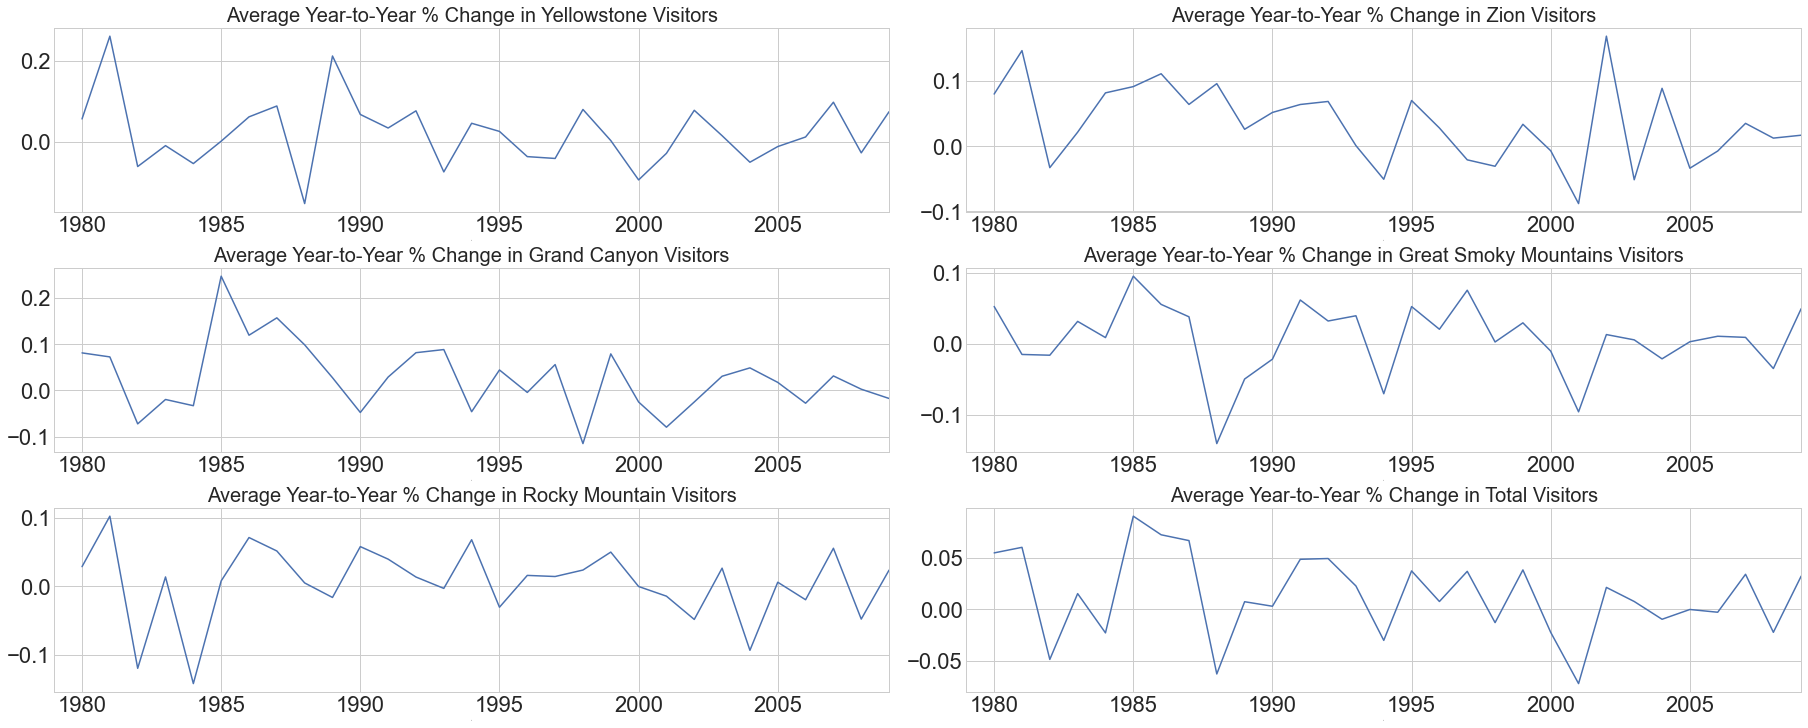

In [42]:
#Let's look at the yearly change in park visitors individually and overall:
rows = 3
cols = 2
plt.rcParams['axes.labelsize'] = 1
plt.rcParams['axes.titlesize'] = 20
plt.figure(figsize=(25, 10), constrained_layout=True)
plt.style.use('seaborn-whitegrid')


plt.subplot(rows, cols, 1)
(train.yellowstone.resample('y').mean().diff() / train.yellowstone.resample('y').mean().shift()).plot(title='Average Year-to-Year % Change in Yellowstone Visitors')
plt.subplot(rows, cols, 2)
(train.zion.resample('y').mean().diff() / train.zion.resample('y').mean().shift()).plot(title='Average Year-to-Year % Change in Zion Visitors')
plt.subplot(rows, cols, 3)
(train.grand_canyon.resample('y').mean().diff() / train.grand_canyon.resample('y').mean().shift()).plot(title='Average Year-to-Year % Change in Grand Canyon Visitors')
plt.subplot(rows, cols, 4)
(train.great_smoky_mtns.resample('y').mean().diff() / train.great_smoky_mtns.resample('y').mean().shift()).plot(title='Average Year-to-Year % Change in Great Smoky Mountains Visitors')
plt.subplot(rows, cols, 5)
(train.rocky_mtn.resample('y').mean().diff() / train.rocky_mtn.resample('y').mean().shift()).plot(title='Average Year-to-Year % Change in Rocky Mountain Visitors')
plt.subplot(rows, cols, 6)
(train.total_visits.resample('y').mean().diff() / train.total_visits.resample('y').mean().shift()).plot(title='Average Year-to-Year % Change in Total Visitors')

### Takeaway:
- the underlying trend is not super clear - most parks tend to normalize around the x-axis for yearly change, with most experiencing spikes intermittently
- let's investigate the trends with autocorrelation and seasonal decomposition

### Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

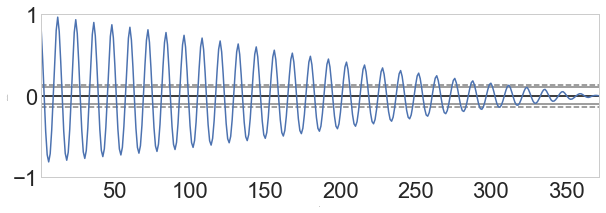

In [43]:
# Total Visits
pd.plotting.autocorrelation_plot(train.total_visits.resample('M').mean())


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

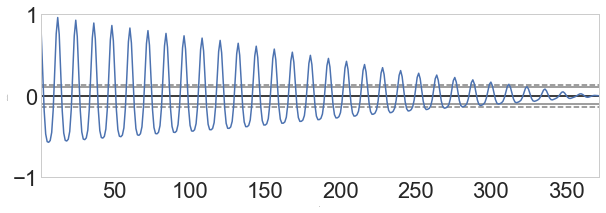

In [44]:
# Yellowstone
pd.plotting.autocorrelation_plot(train.yellowstone.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

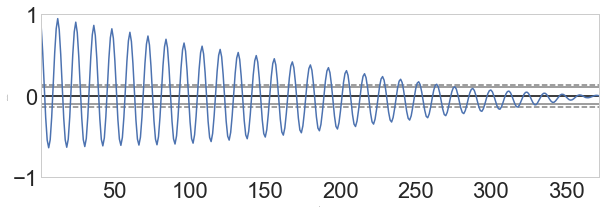

In [45]:
# Zion
pd.plotting.autocorrelation_plot(train.zion.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

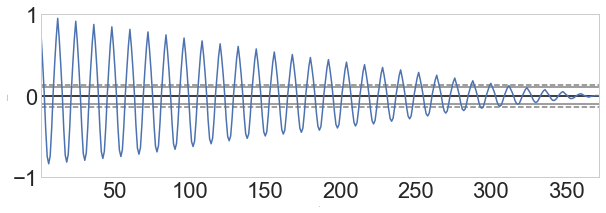

In [46]:
# GSM
pd.plotting.autocorrelation_plot(train.great_smoky_mtns.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

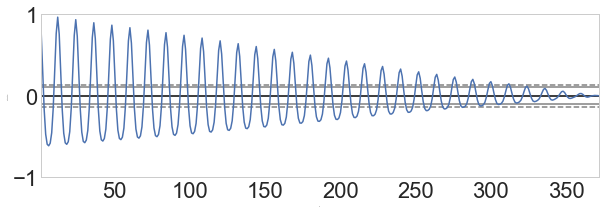

In [47]:
# Rocky MTN
pd.plotting.autocorrelation_plot(train.rocky_mtn.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

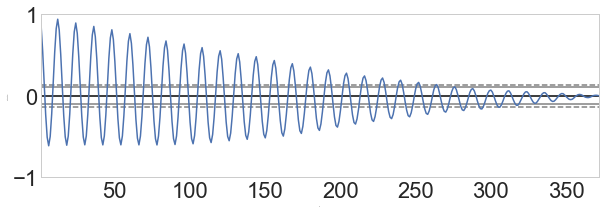

In [48]:
# Grand Canyon
pd.plotting.autocorrelation_plot(train.grand_canyon.resample('M').mean())

### Autocorrelation takeaways:
- the correlation remains strong until about 240 months, or 2 decades. the correlation within the first 120 months/first decade is exceptionally strong

## Seasonal Decomposition

In [49]:
y1 = train.total_visits.resample('M').mean()
y2 = train.yellowstone.resample('M').mean()
y3 = train.zion.resample('M').mean()
y4 = train.grand_canyon.resample('M').mean()
y5 = train.great_smoky_mtns.resample('M').mean()
y6 = train.rocky_mtn.resample('M').mean()

result1 = sm.tsa.seasonal_decompose(y1)
result2 = sm.tsa.seasonal_decompose(y2)
result3 = sm.tsa.seasonal_decompose(y3)
result4 = sm.tsa.seasonal_decompose(y4)
result5 = sm.tsa.seasonal_decompose(y5)
result6 = sm.tsa.seasonal_decompose(y6)

In [50]:
decomposition1 = pd.DataFrame({
    'y_total_visits' : result1.observed,
    'trend' : result1.trend,
    'seasonal' : result1.seasonal,
    'residual' : result1.resid
})

decomposition2 = pd.DataFrame({
    'y_yellowstone' : result2.observed,
    'trend' : result2.trend,
    'seasonal' : result2.seasonal,
    'residual' : result2.resid
})

decomposition3 = pd.DataFrame({
    'y_zion' : result3.observed,
    'trend' : result3.trend,
    'seasonal' : result3.seasonal,
    'residual' : result3.resid
})

decomposition4 = pd.DataFrame({
    'y_grand_canyon' : result4.observed,
    'trend' : result4.trend,
    'seasonal' : result4.seasonal,
    'residual' : result4.resid
})

decomposition5 = pd.DataFrame({
    'y_great_smoky_mtns' : result5.observed,
    'trend' : result5.trend,
    'seasonal' : result5.seasonal,
    'residual' : result5.resid
})

decomposition6 = pd.DataFrame({
    'y_rocky_mtns' : result6.observed,
    'trend' : result6.trend,
    'seasonal' : result6.seasonal,
    'residual' : result6.resid
})

In [51]:
decomposition1['month'] = decomposition1.index.strftime('%m')
decomposition2['month'] = decomposition2.index.strftime('%m')
decomposition3['month'] = decomposition3.index.strftime('%m')
decomposition4['month'] = decomposition4.index.strftime('%m')
decomposition5['month'] = decomposition5.index.strftime('%m')
decomposition6['month'] = decomposition6.index.strftime('%m')


decomposition1.head(20)

y_total_visits         trend      seasonal       residual month
date                                                                       
1979-01-31        253447.0           NaN -1.202948e+06            NaN    01
1979-02-28        336836.0           NaN -1.157562e+06            NaN    02
1979-03-31        517052.0           NaN -8.534117e+05            NaN    03
1979-04-30        938402.0           NaN -5.055044e+05            NaN    04
1979-05-31       1182558.0           NaN  1.344250e+04            NaN    05
1979-06-30       2130857.0           NaN  1.131560e+06            NaN    06
1979-07-31       2879067.0  1.308337e+06  1.977457e+06 -406727.369097    07
1979-08-31       2906446.0  1.312625e+06  1.627198e+06  -33376.844097    08
1979-09-30       1886179.0  1.311923e+06  6.490249e+05  -74768.985764    09
1979-10-31       1653673.0  1.306885e+06  2.532191e+05   93569.219792    10
1979-11-30        568170.0  1.309802e+06 -8.225091e+05   80877.017014    11
1979-12-31        400783.0  1.321519e+06 -1.109967e+06  189230.196181    12
1980-01-31        346592.0  1.338353e+06 -1.202948e+06  211187.032292    01
1980-02-29        346606.0  1.359817e+06 -1.157562e+06  144351.403125    02
1980-03-31        490437.0  1.366673e+06 -8.534117e+05  -22824.271875    03
1980-04-30        844095.0  1.364195e+06 -5.055044e+05  -14595.680208    04
1980-05-31       1346881.0  1.368890e+06  1.344250e+04  -35451.289931    05
1980-06-30       2247749.0  1.374707e+06  1.131560e+06 -258518.510764    06
1980-07-31       3166175.0  1.377587e+06  1.977457e+06 -188869.410764    07
1980-08-31       3134484.0  1.380894e+06  1.627198e+06  126392.614236    08

<AxesSubplot:title={'center':'rocky mtn residual'}, xlabel='month'>

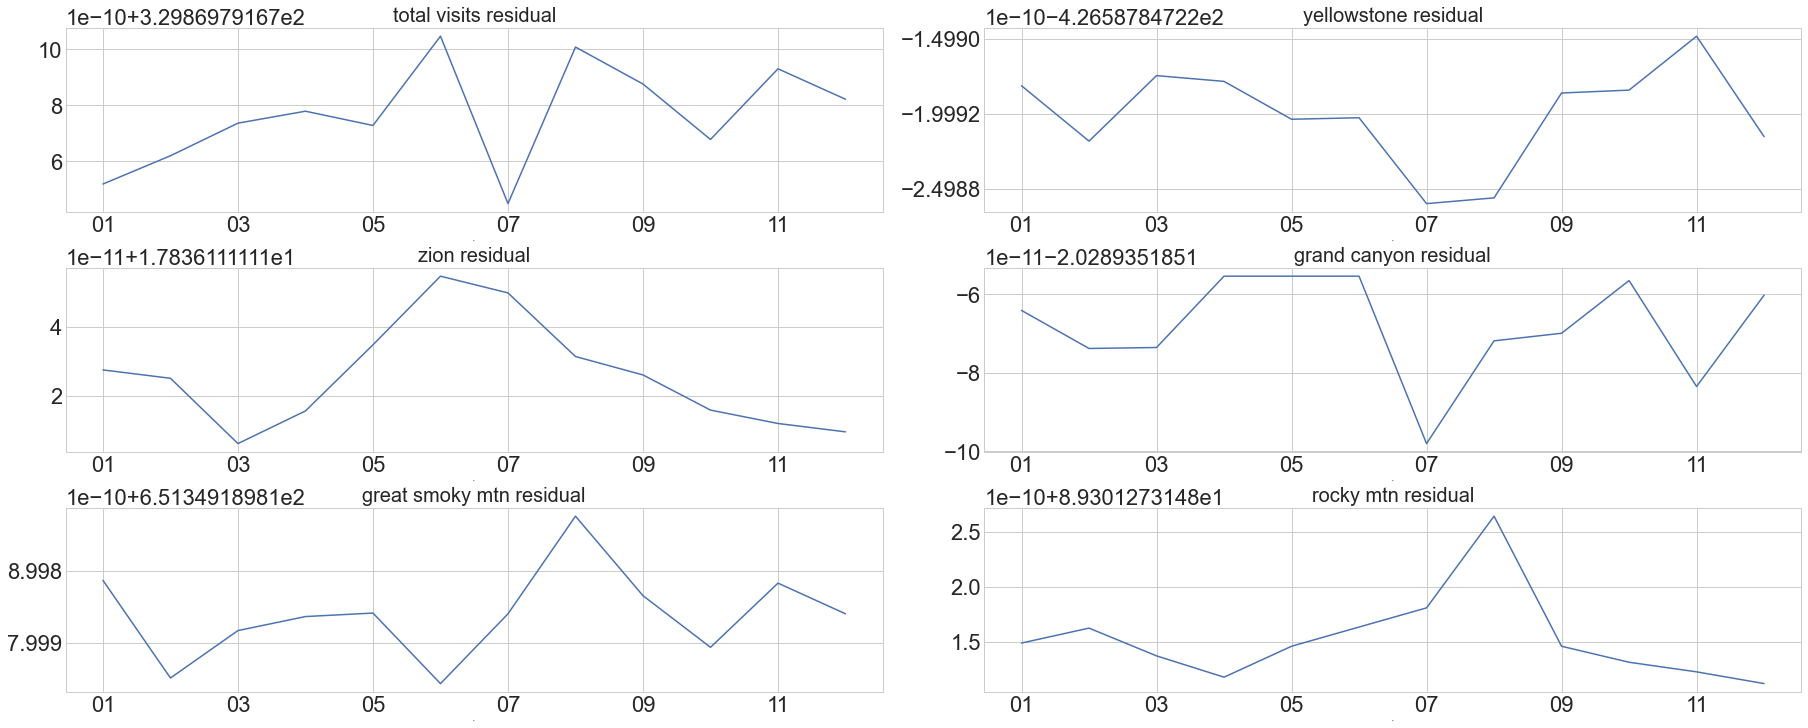

In [52]:
rows = 3
cols = 2

plt.rcParams['axes.labelsize'] = 1
plt.rcParams['axes.titlesize'] = 20
plt.figure(figsize=(25, 10), constrained_layout=True)
plt.style.use('seaborn-whitegrid')

plt.subplot(rows, cols, 1)
decomposition1.groupby('month').residual.mean().plot(title='total visits residual')
plt.subplot(rows, cols, 2)
decomposition2.groupby('month').residual.mean().plot(title='yellowstone residual')
plt.subplot(rows, cols, 3)
decomposition3.groupby('month').residual.mean().plot(title='zion residual')
plt.subplot(rows, cols, 4)
decomposition4.groupby('month').residual.mean().plot(title='grand canyon residual')
plt.subplot(rows, cols, 5)
decomposition5.groupby('month').residual.mean().plot(title='great smoky mtn residual')
plt.subplot(rows, cols, 6)
decomposition6.groupby('month').residual.mean().plot(title='rocky mtn residual')


The residual range is: 371468.7392361115 - -518002.4274305552 = 889471.1666666667
The abs average residual is: 87067.29065586416


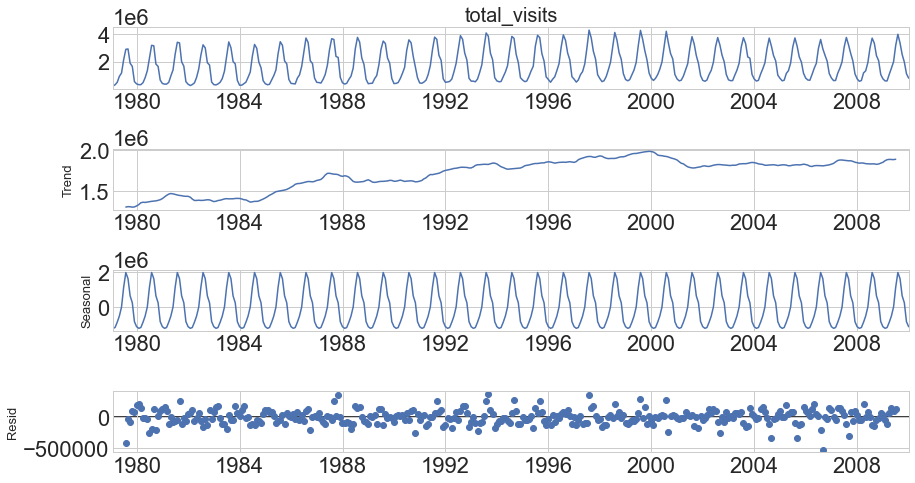

In [53]:
# plt.figure(figsize=(25, 10), constrained_layout=True)
plt.rc('figure', figsize=(13, 7))
plt.rcParams['axes.labelsize'] = 13
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
result1.plot()
print("The residual range is:", result1.resid.max(), '-', result1.resid.min(), '=', (result1.resid.max()-result1.resid.min()))
print("The abs average residual is:", result1.resid.abs().mean())
None


The residual range is: 92490.47881944448 - -175126.01701388892 = 267616.4958333334
The abs average residual is: 28589.666504629622


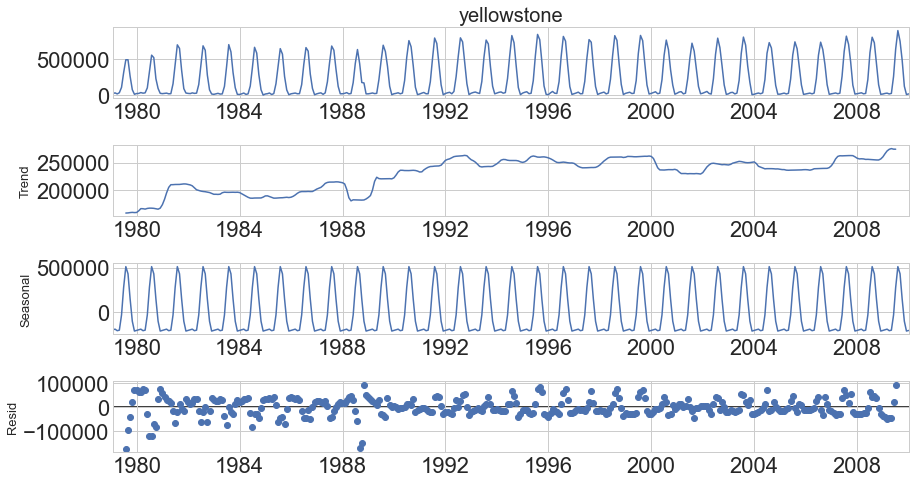

In [54]:
# plt.figure(figsize=(25, 10), constrained_layout=True)
plt.rc('figure', figsize=(13, 7))
plt.rcParams['axes.labelsize'] = 13
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
result2.plot()
print("The residual range is:", result2.resid.max(), '-', result2.resid.min(), '=', (result2.resid.max()-result2.resid.min()))
print("The abs average residual is:", result2.resid.abs().mean())
None

The residual range is: 75086.34722222228 - -59741.266666666656 = 134827.61388888894
The abs average residual is: 19630.506766975315


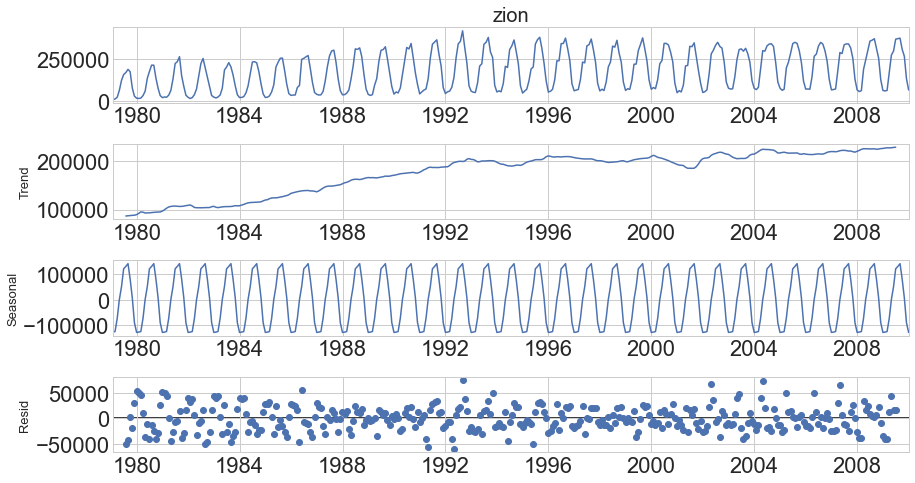

In [55]:
# plt.figure(figsize=(25, 10), constrained_layout=True)
plt.rc('figure', figsize=(13, 7))
plt.rcParams['axes.labelsize'] = 13
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
result3.plot()
print("The residual range is:", result3.resid.max(), '-', result3.resid.min(), '=', (result3.resid.max()-result3.resid.min()))
print("The abs average residual is:", result3.resid.abs().mean())
None

The residual range is: 150086.45439814814 - -136157.16643518515 = 286243.6208333333
The abs average residual is: 29167.56597993826


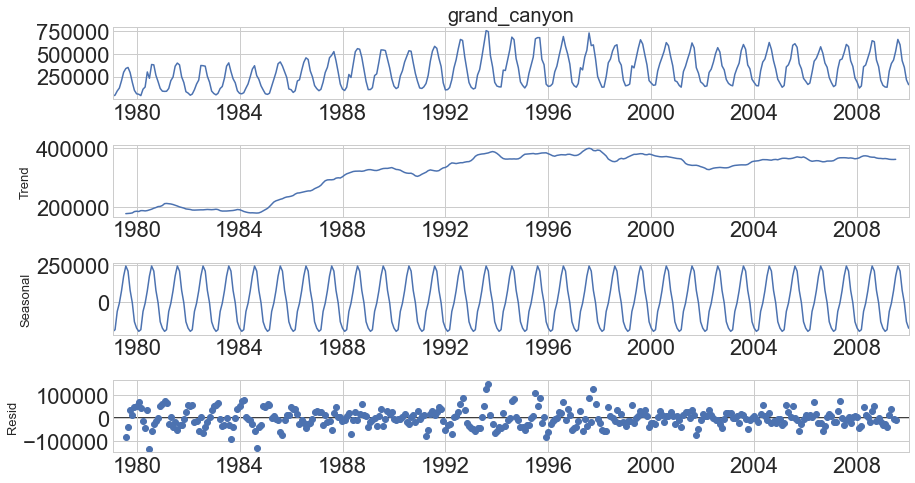

In [56]:
# plt.figure(figsize=(25, 10), constrained_layout=True)
plt.rc('figure', figsize=(13, 7))
plt.rcParams['axes.labelsize'] = 13
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
result4.plot()
print("The residual range is:", result4.resid.max(), '-', result4.resid.min(), '=', (result4.resid.max()-result4.resid.min()))
print("The abs average residual is:", result4.resid.abs().mean())
None

The residual range is: 357974.6047453703 - -311092.888310185 = 669067.4930555553
The abs average residual is: 66460.51683706272


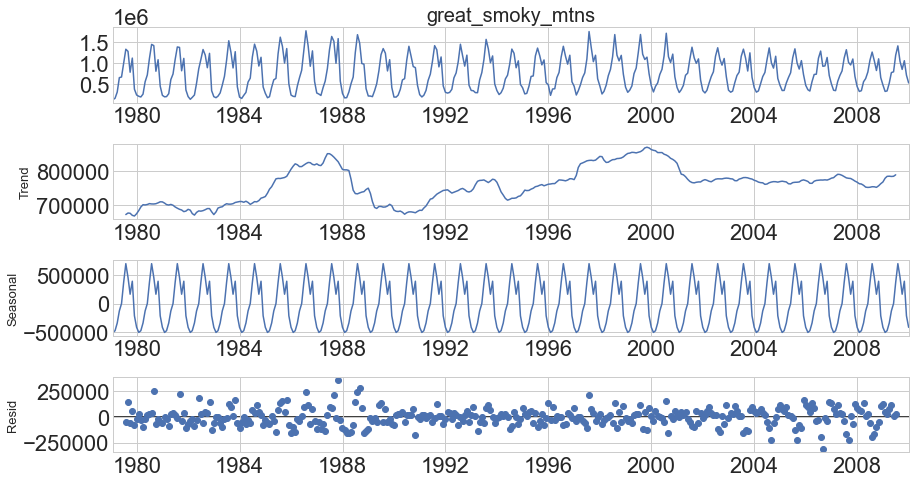

In [57]:
# plt.figure(figsize=(25, 10), constrained_layout=True)
plt.rc('figure', figsize=(13, 7))
plt.rcParams['axes.labelsize'] = 13
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
result5.plot()
print("The residual range is:", result5.resid.max(), '-', result5.resid.min(), '=', (result5.resid.max()-result5.resid.min()))
print("The abs average residual is:", result5.resid.abs().mean())
None

The residual range is: 96438.56655092601 - -98287.54039351846 = 194726.10694444447
The abs average residual is: 21081.90688335905


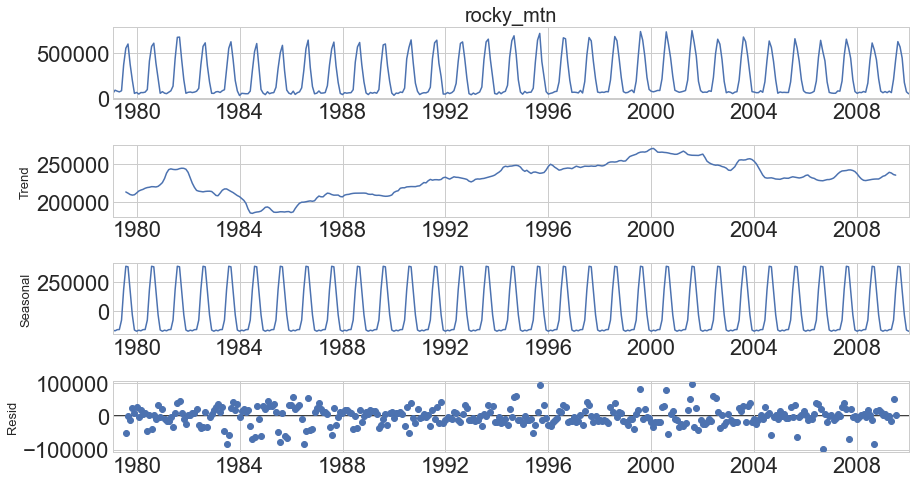

In [58]:
# plt.figure(figsize=(25, 10), constrained_layout=True)
plt.rc('figure', figsize=(13, 7))
plt.rcParams['axes.labelsize'] = 13
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
result6.plot()
print("The residual range is:", result6.resid.max(), '-', result6.resid.min(), '=', (result6.resid.max()-result6.resid.min()))
print("The abs average residual is:", result6.resid.abs().mean())
None

## Seasonal Decomposition Takeaways
- the seasonal influence is present in every park measured
- there are varying amounts of residual error by park...when I model I'm going to produce an aggregate model, and then seperate models for eaach park.

In [59]:
data = {'total_visitors': [3, 2, 1, 0], 'row_2': ['a', 'b', 'c', 'd']}
pd.DataFrame.from_dict(data, orient='index', columns=['A', 'B', 'C', 'D'])

A  B  C  D
total_visitors  3  2  1  0
row_2           a  b  c  d

In [60]:
# Modeling
# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt



### Check the length of the Train, Validate, Test sections against the total DF length

In [61]:
len(train) + len(validate) + len(test) == len(df)

True

In [62]:
train = train.drop(columns=['year', 'month'])
train.head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns  \
date                                                                         
1979-01-01        23605         37002      53585    8994            130261   
1979-02-01        31992         46043      85931   12106            160764   
1979-03-01        17813         91927      75070   23079            309163   
1979-04-01        34095        123643      66873   63306            650485   
1979-05-01       108952        205048      79577  122964            666017   

            total_visits  
date                      
1979-01-01        253447  
1979-02-01        336836  
1979-03-01        517052  
1979-04-01        938402  
1979-05-01       1182558

In [63]:
validate.head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns  \
date                                                                         
2010-01-01        25595        120409      64618   54928            303318   
2010-02-01        29108        124573      44576   62099            239587   
2010-03-01        21028        312903      70117  171079            505950   
2010-04-01        32763        375136      69097  277599            848946   
2010-05-01       250445        399037     180710  304278            792980   

            total_visits  
date                      
2010-01-01        568868  
2010-02-01        499943  
2010-03-01       1081077  
2010-04-01       1603541  
2010-05-01       1927450

In [64]:
test.head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns  \
date                                                                         
2016-01-01        30621        189103     115207   84145            379730   
2016-02-01        36327        214361     105125  117510            353532   
2016-03-01        22924        504295     135053  359920            778211   
2016-04-01        59253        464922     129967  395768            859420   
2016-05-01       444630        588591     285868  447976           1018224   

            total_visits  
date                      
2016-01-01        798806  
2016-02-01        826855  
2016-03-01       1800403  
2016-04-01       1909330  
2016-05-01       2785289

In [65]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [66]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [67]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

Empty DataFrame
Columns: [model_type, target_var, rmse]
Index: []

In [68]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Predictions

### Last Observed Value

In [69]:
# the last observed value in the train total visits column is:
train['total_visits'][-1:]

date
2009-12-01    815771
Name: total_visits, dtype: int64

In [70]:
# last total visit
last_total_visit = train['total_visits'][-1:][0]
last_yellowstone = train['yellowstone'][-1:][0]
last_zion = train['zion'][-1:][0]
last_grand_canyon = train['grand_canyon'][-1:][0]
last_great_smoky_mtns = train['great_smoky_mtns'][-1:][0]
last_rocky_mtn = train['rocky_mtn'][-1:][0]

In [71]:
yhat_df = pd.DataFrame({
    'total_visits': [last_total_visit],
    'yellowstone': [last_yellowstone],
    'zion': [last_zion],
    'grand_canyon': [last_grand_canyon],
    'great_smoky_mtns':[last_great_smoky_mtns],
    'rocky_mtn': [last_rocky_mtn]},
    index=validate.index)

yhat_df.head()

total_visits  yellowstone   zion  grand_canyon  great_smoky_mtns  \
date                                                                           
2010-01-01        815771        18107  65601        161047            524771   
2010-02-01        815771        18107  65601        161047            524771   
2010-03-01        815771        18107  65601        161047            524771   
2010-04-01        815771        18107  65601        161047            524771   
2010-05-01        815771        18107  65601        161047            524771   

            rocky_mtn  
date                   
2010-01-01      46245  
2010-02-01      46245  
2010-03-01      46245  
2010-04-01      46245  
2010-05-01      46245

In [72]:
yhat_df.describe()

total_visits  yellowstone     zion  grand_canyon  great_smoky_mtns  \
count          72.0         72.0     72.0          72.0              72.0   
mean       815771.0      18107.0  65601.0      161047.0          524771.0   
std             0.0          0.0      0.0           0.0               0.0   
min        815771.0      18107.0  65601.0      161047.0          524771.0   
25%        815771.0      18107.0  65601.0      161047.0          524771.0   
50%        815771.0      18107.0  65601.0      161047.0          524771.0   
75%        815771.0      18107.0  65601.0      161047.0          524771.0   
max        815771.0      18107.0  65601.0      161047.0          524771.0   

       rocky_mtn  
count       72.0  
mean     46245.0  
std          0.0  
min      46245.0  
25%      46245.0  
50%      46245.0  
75%      46245.0  
max      46245.0

yellowstone -- RMSE: 432517


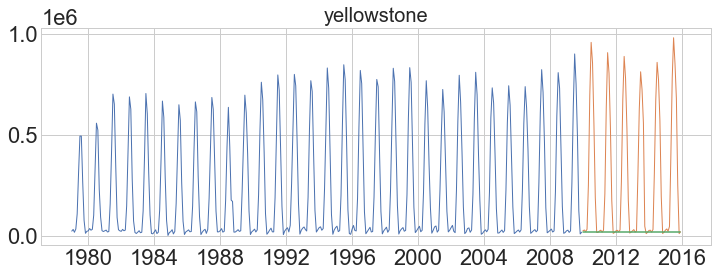

grand_canyon -- RMSE: 289927


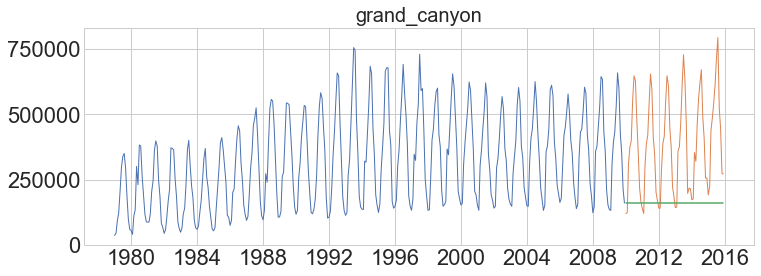

rocky_mtn -- RMSE: 334293


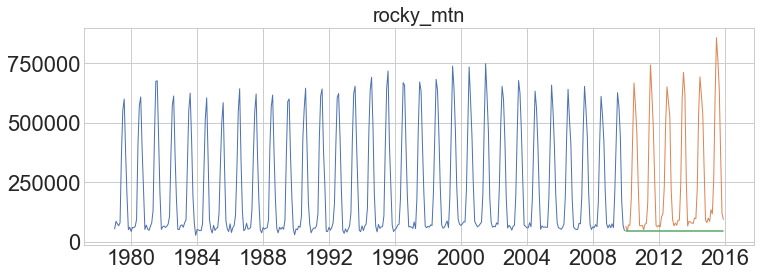

zion -- RMSE: 225677


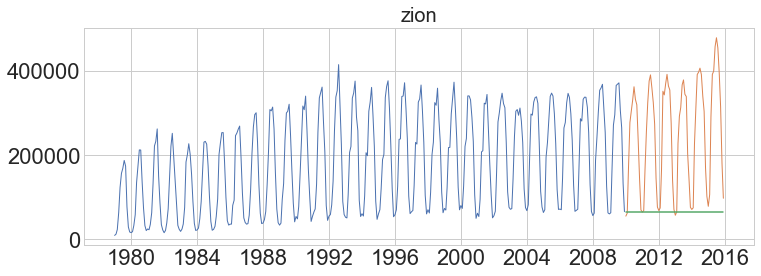

great_smoky_mtns -- RMSE: 468014


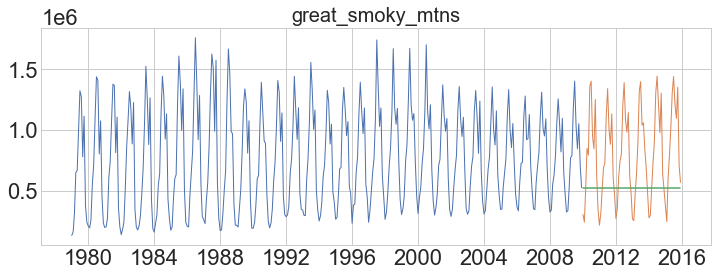

total_visits -- RMSE: 1692378


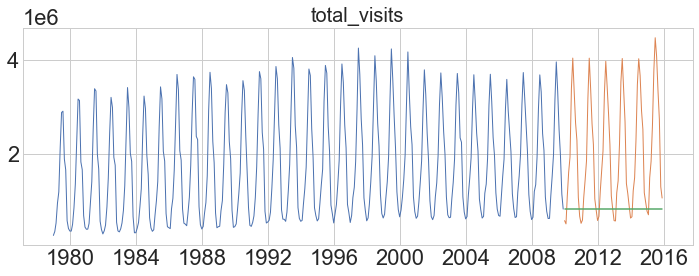

In [73]:
for col in train.columns:
    plot_and_eval(col)

In [74]:
train.columns

Index(['yellowstone', 'grand_canyon', 'rocky_mtn', 'zion', 'great_smoky_mtns',
       'total_visits'],
      dtype='object')

In [75]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                                target_var = col)
    
eval_df.head(6)

model_type        target_var       rmse
0  last_observed_value       yellowstone   432517.0
1  last_observed_value      grand_canyon   289927.0
2  last_observed_value         rocky_mtn   334293.0
3  last_observed_value              zion   225677.0
4  last_observed_value  great_smoky_mtns   468014.0
5  last_observed_value      total_visits  1692378.0

### Simple Average

In [76]:
avg_total_visits = train['total_visits'].mean()
avg_yellowstone = train['yellowstone'].mean()
avg_zion = train['zion'].mean()
avg_rocky_mtn = train['rocky_mtn'].mean()
avg_great_smoky_mtns = train['great_smoky_mtns'].mean()
avg_grand_canyon = train['grand_canyon'].mean()

In [77]:
def make_predictions(avg_total_visits=None, avg_grand_canyon=None, avg_great_smoky_mtns=None, avg_yellowstone=None, avg_zion=None, avg_rocky_mtn=None ):
    yhat_df = pd.DataFrame({
        'total_visits': [avg_total_visits],
        'yellowstone': [avg_yellowstone],
        'zion': [avg_zion],
        'grand_canyon': [avg_grand_canyon],
        'rocky_mtn': [avg_rocky_mtn],
        'great_smoky_mtns': [avg_great_smoky_mtns]
    }, index=validate.index)
    return yhat_df

In [78]:
yhat_df = make_predictions(avg_total_visits, avg_yellowstone, avg_zion, avg_grand_canyon, avg_rocky_mtn, avg_great_smoky_mtns)

yhat_df.head()

total_visits    yellowstone           zion   grand_canyon  \
date                                                                    
2010-01-01  1.709064e+06  314796.639785  230801.056452  228887.241935   
2010-02-01  1.709064e+06  314796.639785  230801.056452  228887.241935   
2010-03-01  1.709064e+06  314796.639785  230801.056452  228887.241935   
2010-04-01  1.709064e+06  314796.639785  230801.056452  228887.241935   
2010-05-01  1.709064e+06  314796.639785  230801.056452  228887.241935   

                rocky_mtn  great_smoky_mtns  
date                                         
2010-01-01  758635.583333     175943.223118  
2010-02-01  758635.583333     175943.223118  
2010-03-01  758635.583333     175943.223118  
2010-04-01  758635.583333     175943.223118  
2010-05-01  758635.583333     175943.223118

In [79]:
yhat_df.describe().T
# all values will be the same (average value of the series)

count          mean           std           min  \
total_visits       72.0  1.709064e+06  1.875717e-09  1.709064e+06   
yellowstone        72.0  3.147966e+05  4.689291e-10  3.147966e+05   
zion               72.0  2.308011e+05  1.465404e-10  2.308011e+05   
grand_canyon       72.0  2.288872e+05  1.758484e-10  2.288872e+05   
rocky_mtn          72.0  7.586356e+05  5.861614e-10  7.586356e+05   
great_smoky_mtns   72.0  1.759432e+05  2.930807e-10  1.759432e+05   

                           25%           50%           75%           max  
total_visits      1.709064e+06  1.709064e+06  1.709064e+06  1.709064e+06  
yellowstone       3.147966e+05  3.147966e+05  3.147966e+05  3.147966e+05  
zion              2.308011e+05  2.308011e+05  2.308011e+05  2.308011e+05  
grand_canyon      2.288872e+05  2.288872e+05  2.288872e+05  2.288872e+05  
rocky_mtn         7.586356e+05  7.586356e+05  7.586356e+05  7.586356e+05  
great_smoky_mtns  1.759432e+05  1.759432e+05  1.759432e+05  1.759432e+05

yellowstone -- RMSE: 332343


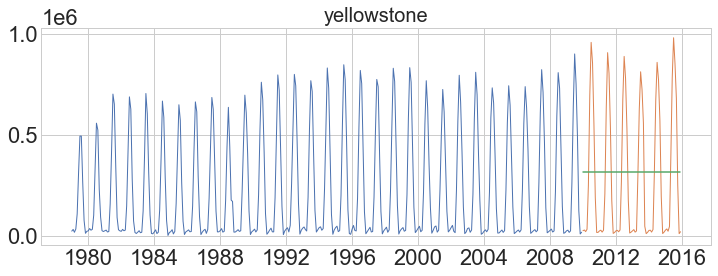

grand_canyon -- RMSE: 240499


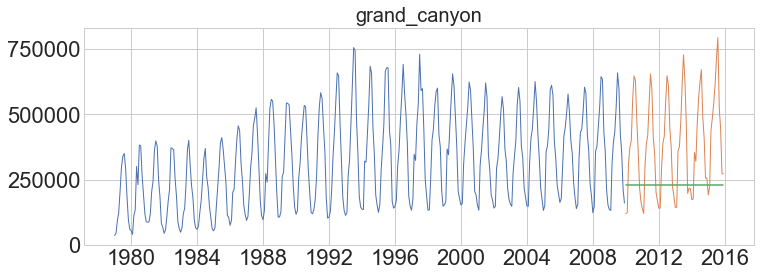

rocky_mtn -- RMSE: 538956


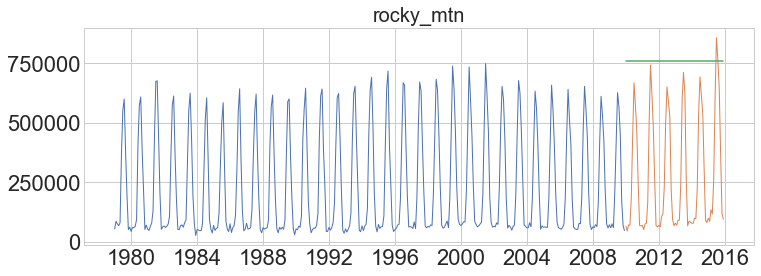

zion -- RMSE: 129562


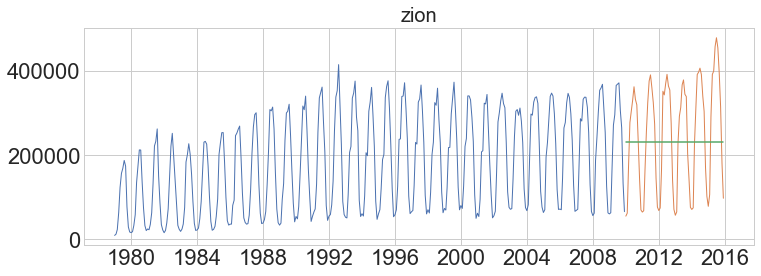

great_smoky_mtns -- RMSE: 734681


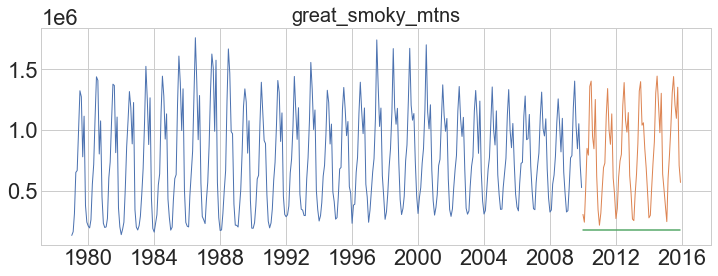

total_visits -- RMSE: 1227353


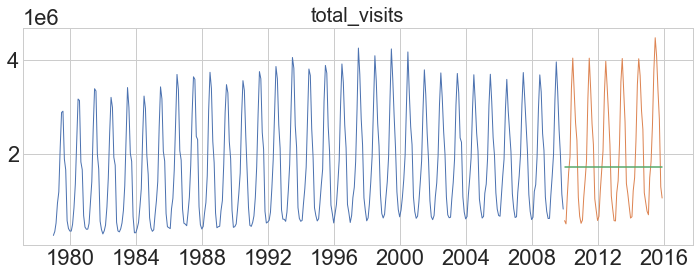

In [80]:
# plot and evaluate
for col in train.columns:
    plot_and_eval(col)

In [81]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_avg', target_var=col)

eval_df.head(20)

model_type        target_var       rmse
0   last_observed_value       yellowstone   432517.0
1   last_observed_value      grand_canyon   289927.0
2   last_observed_value         rocky_mtn   334293.0
3   last_observed_value              zion   225677.0
4   last_observed_value  great_smoky_mtns   468014.0
5   last_observed_value      total_visits  1692378.0
6            simple_avg       yellowstone   332343.0
7            simple_avg      grand_canyon   240499.0
8            simple_avg         rocky_mtn   538956.0
9            simple_avg              zion   129562.0
10           simple_avg  great_smoky_mtns   734681.0
11           simple_avg      total_visits  1227353.0

In [82]:
eval_df[eval_df.target_var=='yellowstone']

model_type   target_var      rmse
0  last_observed_value  yellowstone  432517.0
6           simple_avg  yellowstone  332343.0

In [83]:
# the simple average was a better gauge than last observed value. Let's compute a rolling average now:
period=30
rolling_total_visits=train['total_visits'].rolling(period).mean()[-1]
rolling_yellowstone=train['yellowstone'].rolling(period).mean()[-1]
rolling_zion=train['zion'].rolling(period).mean()[-1]
rolling_great_smoky_mtns=train['great_smoky_mtns'].rolling(period).mean()[-1]
rolling_rocky_mtn=train['rocky_mtn'].rolling(period).mean()[-1]
rolling_grand_canyon=train['grand_canyon'].rolling(period).mean()[-1]

print(rolling_total_visits, rolling_yellowstone, rolling_rocky_mtn, rolling_great_smoky_mtns, rolling_zion, rolling_grand_canyon)

1938437.6 284495.8 252079.2 800710.0666666667 228839.66666666666 372312.86666666664


In [84]:

yhat_df=make_predictions(rolling_total_visits, rolling_yellowstone, rolling_rocky_mtn, rolling_great_smoky_mtns, rolling_zion, rolling_grand_canyon)
yhat_df.head()

total_visits    yellowstone           zion  grand_canyon  \
date                                                                   
2010-01-01     1938437.6  800710.066667  228839.666667      284495.8   
2010-02-01     1938437.6  800710.066667  228839.666667      284495.8   
2010-03-01     1938437.6  800710.066667  228839.666667      284495.8   
2010-04-01     1938437.6  800710.066667  228839.666667      284495.8   
2010-05-01     1938437.6  800710.066667  228839.666667      284495.8   

                rocky_mtn  great_smoky_mtns  
date                                         
2010-01-01  372312.866667          252079.2  
2010-02-01  372312.866667          252079.2  
2010-03-01  372312.866667          252079.2  
2010-04-01  372312.866667          252079.2  
2010-05-01  372312.866667          252079.2

yellowstone -- RMSE: 604353


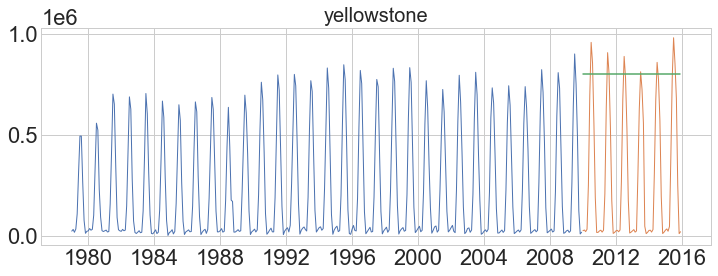

grand_canyon -- RMSE: 207880


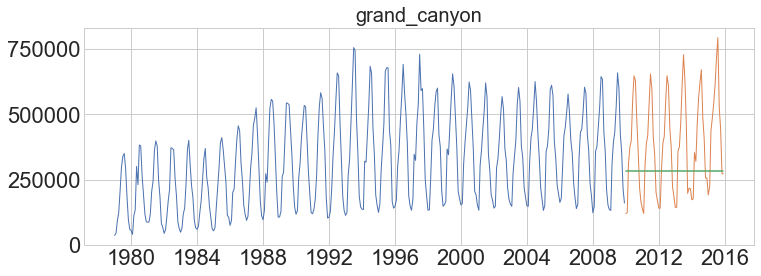

rocky_mtn -- RMSE: 259975


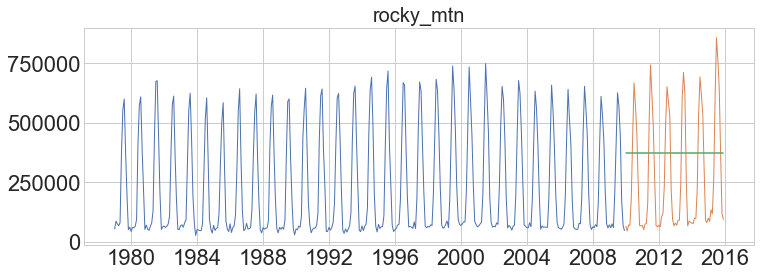

zion -- RMSE: 129890


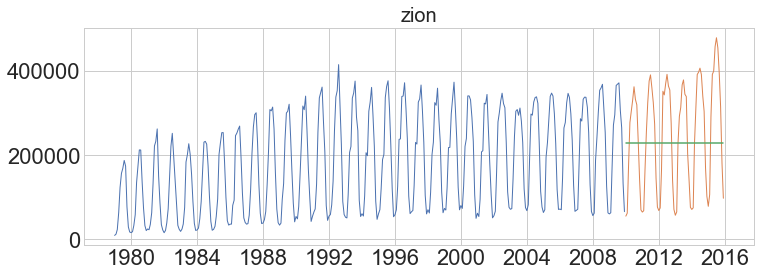

great_smoky_mtns -- RMSE: 670070


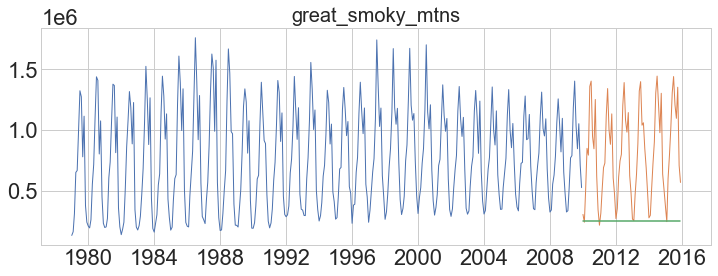

total_visits -- RMSE: 1189653


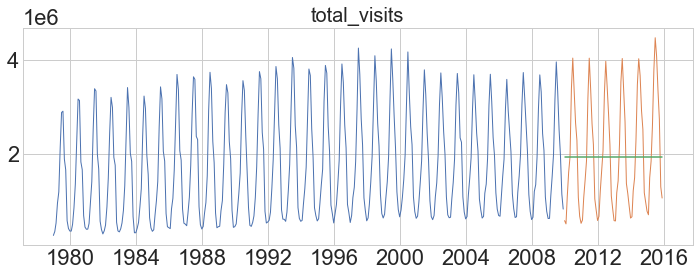

In [85]:
for col in train.columns:
    plot_and_eval(col)

In [86]:
for col in train.columns:
    eval_df = append_eval_df(target_var=col, model_type='30d_moving_average')
eval_df[eval_df.model_type=='30d_moving_average']

model_type        target_var       rmse
12  30d_moving_average       yellowstone   604353.0
13  30d_moving_average      grand_canyon   207880.0
14  30d_moving_average         rocky_mtn   259975.0
15  30d_moving_average              zion   129890.0
16  30d_moving_average  great_smoky_mtns   670070.0
17  30d_moving_average      total_visits  1189653.0

In [87]:
eval_df[eval_df.target_var=='total_visits'].sort_values(by='rmse',ascending=True)

model_type    target_var       rmse
17   30d_moving_average  total_visits  1189653.0
11           simple_avg  total_visits  1227353.0
5   last_observed_value  total_visits  1692378.0

In [88]:
## Holt's Linear Trend:
# use the optimized feature for dampening, and smoothing

for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_total_visits = model.predict(start = validate.index[0],
    end=validate.index[-1])
    yhat_df[col] = yhat_total_visits

yhat_total_visits

2010-01-01    4.484530e+05
2010-02-01    8.716433e+04
2010-03-01   -2.705114e+05
2010-04-01   -6.246104e+05
2010-05-01   -9.751684e+05
                  ...     
2015-08-01   -1.725521e+07
2015-09-01   -1.743946e+07
2015-10-01   -1.762187e+07
2015-11-01   -1.780245e+07
2015-12-01   -1.798123e+07
Freq: MS, Length: 72, dtype: float64

In [89]:
yhat_df

total_visits    yellowstone          zion  grand_canyon  \
date                                                                  
2010-01-01  4.484530e+05   26072.528806 -1.712692e+04  8.590011e+04   
2010-02-01  8.716433e+04   34583.187663 -9.572083e+04  1.821646e+04   
2010-03-01 -2.705114e+05   43008.739932 -1.735288e+05 -4.879036e+04   
2010-04-01 -6.246104e+05   51350.036677 -2.505587e+05 -1.151271e+05   
2010-05-01 -9.751684e+05   59607.920455 -3.268183e+05 -1.808005e+05   
...                  ...            ...           ...           ...   
2015-08-01 -1.725521e+07  443106.943674 -3.868340e+06 -3.230696e+06   
2015-09-01 -1.743946e+07  447447.258382 -3.908422e+06 -3.265213e+06   
2015-10-01 -1.762187e+07  451744.169943 -3.948103e+06 -3.299386e+06   
2015-11-01 -1.780245e+07  455998.112389 -3.987387e+06 -3.333217e+06   
2015-12-01 -1.798123e+07  460209.515410 -4.026279e+06 -3.366709e+06   

               rocky_mtn  great_smoky_mtns  
date                                        
2010-01-01  2.436147e+04     526371.125848  
2010-02-01  3.115199e+03     527032.399651  
2010-03-01 -1.791861e+04     527687.060715  
2010-04-01 -3.874208e+04     528335.175169  
2010-05-01 -5.935732e+04     528976.808478  
...                  ...               ...  
2015-08-01 -1.016736e+06     558774.484726  
2015-09-01 -1.027571e+06     559111.724940  
2015-10-01 -1.038298e+06     559445.592751  
2015-11-01 -1.048918e+06     559776.121885  
2015-12-01 -1.059432e+06     560103.345727  

[72 rows x 6 columns]

yellowstone -- RMSE: 349289


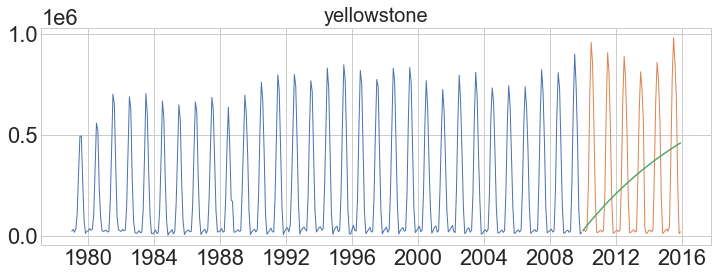

grand_canyon -- RMSE: 2466182


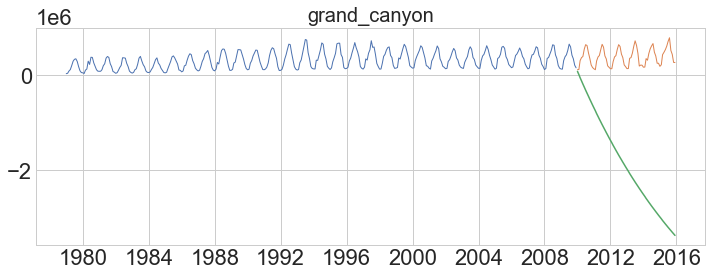

rocky_mtn -- RMSE: 956874


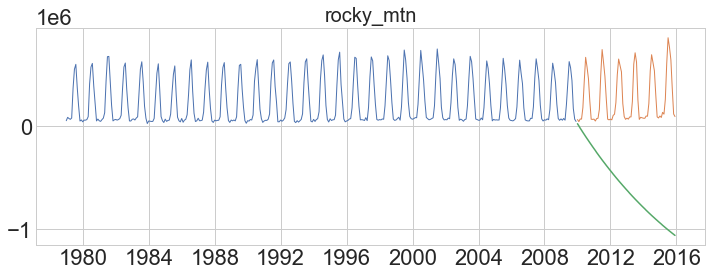

zion -- RMSE: 2779554


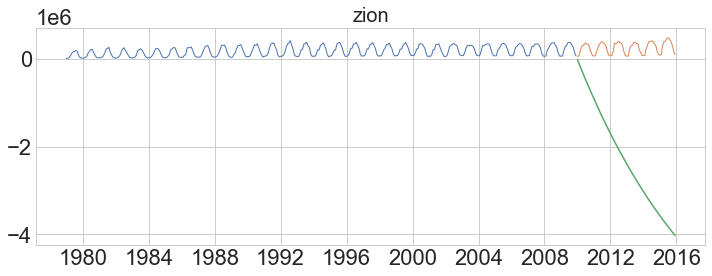

great_smoky_mtns -- RMSE: 454681


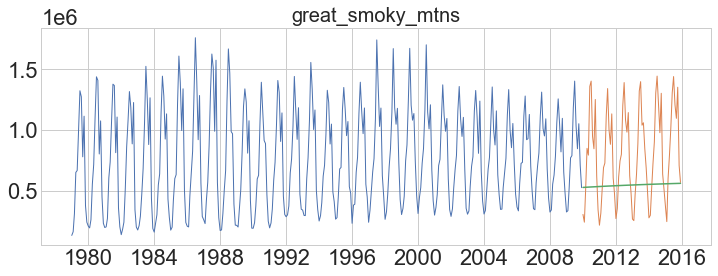

total_visits -- RMSE: 13145375


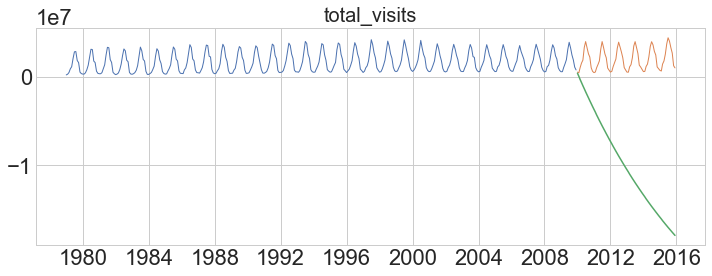

model_type        target_var        rmse
9            simple_avg              zion    129562.0
15   30d_moving_average              zion    129890.0
13   30d_moving_average      grand_canyon    207880.0
3   last_observed_value              zion    225677.0
7            simple_avg      grand_canyon    240499.0
14   30d_moving_average         rocky_mtn    259975.0
1   last_observed_value      grand_canyon    289927.0
6            simple_avg       yellowstone    332343.0
2   last_observed_value         rocky_mtn    334293.0
18      holts_optimized       yellowstone    349289.0
0   last_observed_value       yellowstone    432517.0
22      holts_optimized  great_smoky_mtns    454681.0
4   last_observed_value  great_smoky_mtns    468014.0
8            simple_avg         rocky_mtn    538956.0
12   30d_moving_average       yellowstone    604353.0
16   30d_moving_average  great_smoky_mtns    670070.0
10           simple_avg  great_smoky_mtns    734681.0
20      holts_optimized         rocky_mtn    956874.0
17   30d_moving_average      total_visits   1189653.0
11           simple_avg      total_visits   1227353.0
5   last_observed_value      total_visits   1692378.0
19      holts_optimized      grand_canyon   2466182.0
21      holts_optimized              zion   2779554.0
23      holts_optimized      total_visits  13145375.0

In [90]:
for col in train.columns:
    plot_and_eval(target_var=col)
    eval_df = append_eval_df(model_type='holts_optimized',
            target_var = col)
    
eval_df.sort_values(by='rmse')

#### The Holts linear predicitons were extensions of the occuring trend in a linear direction, and were no sutied for long term, multi-cycle seasonal predcitions. So far, these were the least accurate. Let's test a cyclic prediction model next.

In [91]:
# find y-o-y difference for each month from 1979-2009
yhat_df = train['2004':'2009'] + train.diff(365).mean()

In [92]:
seasonal_additive = train.diff(365).mean()

In [93]:
train.loc['2003':'2009'].head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns  \
date                                                                         
2003-01-01        36387        156481      61472   71233            305430   
2003-02-01        39494        148388      48224   72781            332223   
2003-03-01        17718        274120      63999  143284            533896   
2003-04-01        28877        340245      69226  244910            701080   
2003-05-01       206245        398371     198771  304556            780366   

            total_visits  
date                      
2003-01-01        631003  
2003-02-01        641110  
2003-03-01       1033017  
2003-04-01       1384338  
2003-05-01       1888309

In [94]:
pd.concat([yhat_df.head(1), validate.head(1)])

yellowstone   grand_canyon      rocky_mtn      zion  \
date                                                                
2004-01-01  296226.714286  407793.428571  210482.714286  256649.0   
2010-01-01   25595.000000  120409.000000   64618.000000   54928.0   

            great_smoky_mtns  total_visits  
date                                        
2004-01-01     666664.428571  1.837816e+06  
2010-01-01     303318.000000  5.688680e+05

In [95]:
yhat_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2004-01-01 to 2009-12-01
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   yellowstone       72 non-null     float64
 1   grand_canyon      72 non-null     float64
 2   rocky_mtn         72 non-null     float64
 3   zion              72 non-null     float64
 4   great_smoky_mtns  72 non-null     float64
 5   total_visits      72 non-null     float64
dtypes: float64(6)
memory usage: 3.9 KB


In [96]:
yhat_df.index = validate.index

yellowstone -- RMSE: 237811


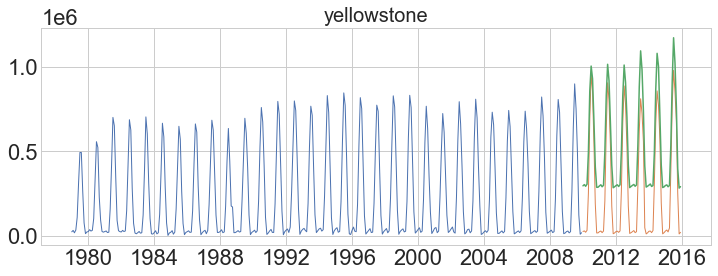

grand_canyon -- RMSE: 239794


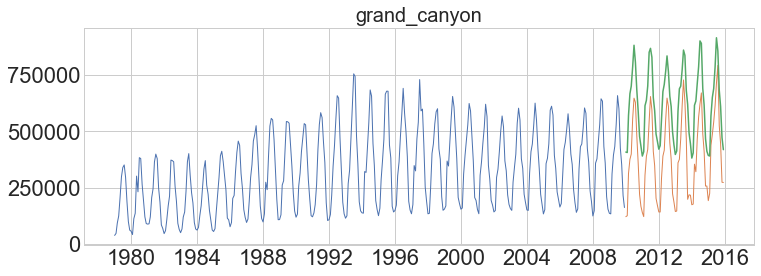

rocky_mtn -- RMSE: 126204


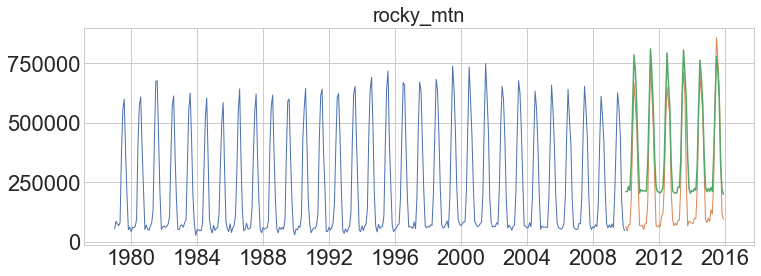

zion -- RMSE: 162103


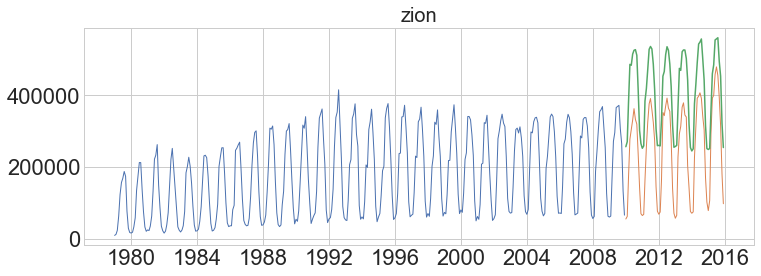

great_smoky_mtns -- RMSE: 338287


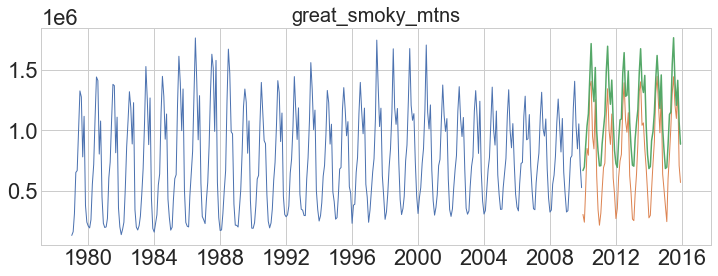

total_visits -- RMSE: 1080822


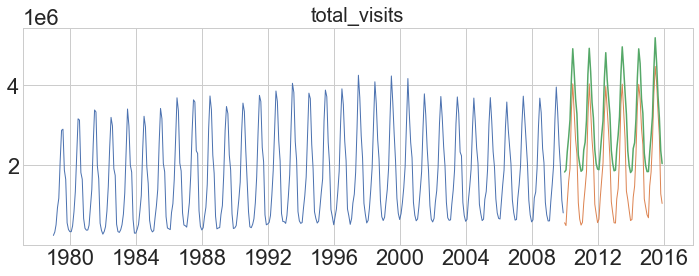

In [97]:
# plot and evaluate
for col in train.columns:
    plot_and_eval(target_var=col)
    eval_df = append_eval_df(model_type='previous_years', target_var=col)


In [98]:
eval_df[eval_df.target_var=='total_visits'].sort_values(ascending=True, by='rmse')

model_type    target_var        rmse
29       previous_years  total_visits   1080822.0
17   30d_moving_average  total_visits   1189653.0
11           simple_avg  total_visits   1227353.0
5   last_observed_value  total_visits   1692378.0
23      holts_optimized  total_visits  13145375.0

### Takeaways: the seasonal model produced a result with the lowest RMSE for the total visitor count, and produced an estimated visitor count with an error of 1.08 mn visitors. This compares favorably to the worst performing model, Holts-Winters, which produced an RMSE rate of 13.145 mn visitors.

## Now I will test the seasonal model on the test portion of the data

In [102]:
len(validate)

72

In [103]:
len(test)

77

In [104]:
test = test['2016':'2021']
test.head()

yellowstone  grand_canyon  rocky_mtn    zion  great_smoky_mtns  \
date                                                                         
2016-01-01        30621        189103     115207   84145            379730   
2016-02-01        36327        214361     105125  117510            353532   
2016-03-01        22924        504295     135053  359920            778211   
2016-04-01        59253        464922     129967  395768            859420   
2016-05-01       444630        588591     285868  447976           1018224   

            total_visits  
date                      
2016-01-01        798806  
2016-02-01        826855  
2016-03-01       1800403  
2016-04-01       1909330  
2016-05-01       2785289

In [105]:
len(test)

72

In [106]:
yhat_df = test + seasonal_additive

In [107]:
yhat_df.index=test.index

In [108]:
yhat_df.head()

yellowstone   grand_canyon      rocky_mtn      zion  \
date                                                                
2016-01-01  304030.714286  446551.428571  267894.714286  272881.0   
2016-02-01  309736.714286  471809.428571  257812.714286  306246.0   
2016-03-01  296333.714286  761743.428571  287740.714286  548656.0   
2016-04-01  332662.714286  722370.428571  282654.714286  584504.0   
2016-05-01  718039.714286  846039.428571  438555.714286  636712.0   

            great_smoky_mtns  total_visits  
date                                        
2016-01-01      7.393774e+05  2.030735e+06  
2016-02-01      7.131794e+05  2.058784e+06  
2016-03-01      1.137858e+06  3.032332e+06  
2016-04-01      1.219067e+06  3.141259e+06  
2016-05-01      1.377871e+06  4.017218e+06

In [109]:
def final_plot(target_var):
    plt.figure(figsize=(20,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

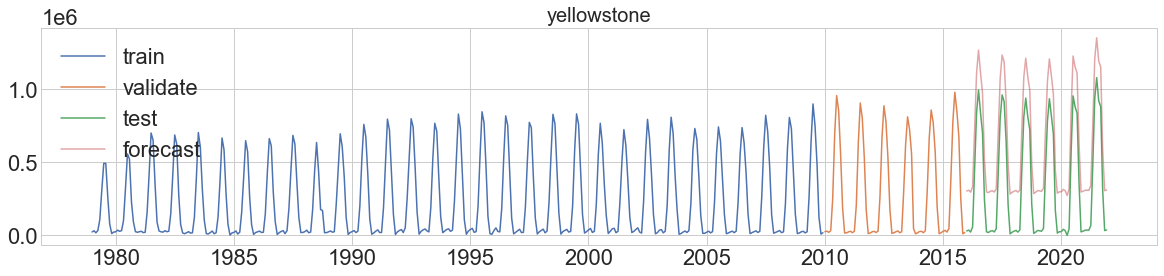

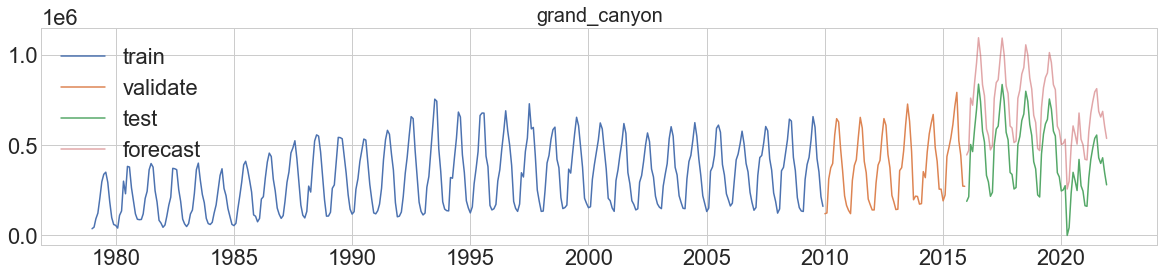

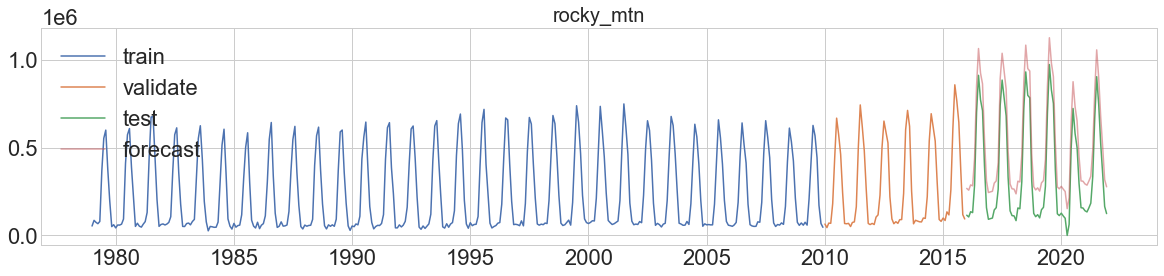

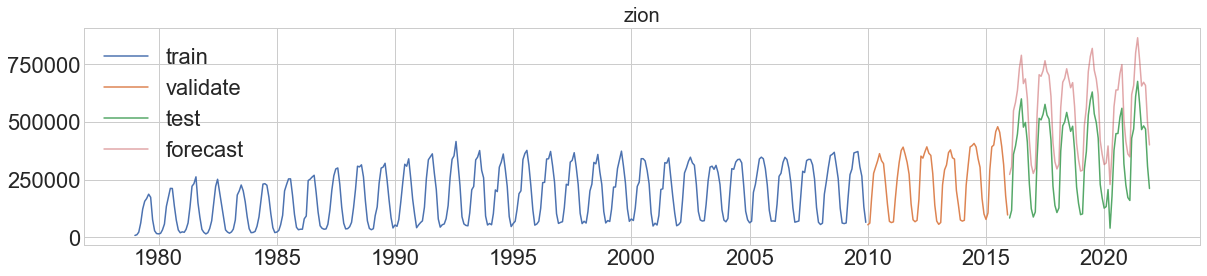

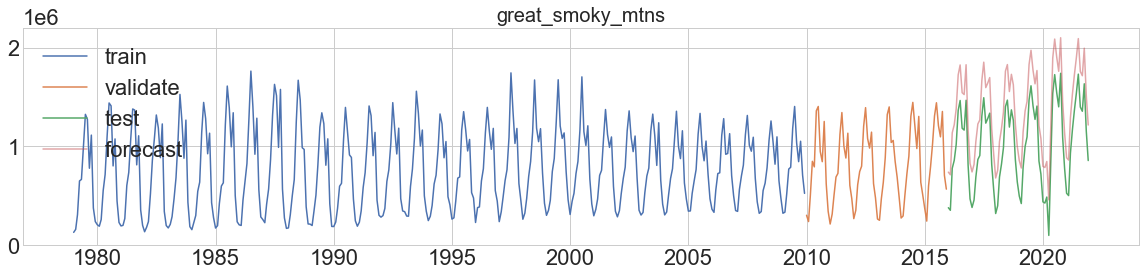

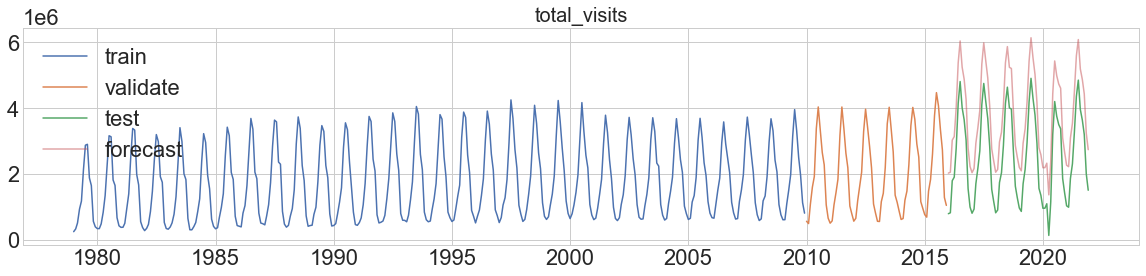

In [110]:
for col in train.columns:
    final_plot(col)

In [111]:
# final RMSE:

final_rmse = round(sqrt(mean_squared_error(validate['total_visits'], yhat_df['total_visits'])), 0)
final_rmse

1791119.0

In [114]:
final_forecast = {'model_type': 'seasonal_final_forecast', 'target_var': 'total_visits',
        'rmse': final_rmse}
eval_df = eval_df.append(final_forecast, ignore_index=True)

In [115]:
eval_df[(eval_df.target_var=='total_visits') & (eval_df.model_type=='seasonal_final_forecast')].sort_values(by='rmse', ascending=True)

model_type    target_var       rmse
30  seasonal_final_forecast  total_visits  1791119.0